# Plan

- 'maximum_speed_limit' 이 랜덤포레스트에서 높은 중요도를 가짐 : 주형 EDA
- test 에 속도 40 제한 구역이 없다.
- 제한속도별로 보팅을 돌린후 다시합치는 계획

In [16]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
train = pd.read_parquet('./train.parquet')
test = pd.read_parquet('./test.parquet')
train = train.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)
test = test.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)

In [42]:
list(train["day_of_week"].value_counts().to_dict().keys())

['금', '수', '목', '일', '토', '화', '월']

In [63]:
train['road_rating'].value_counts()

103    2159511
107    1582214
106     959492
Name: road_rating, dtype: int64

In [64]:
test['road_rating'].value_counts()

107    129304
103    116305
106     45632
Name: road_rating, dtype: int64

<AxesSubplot:>

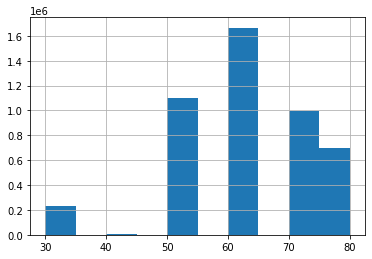

In [14]:
train['maximum_speed_limit'].hist()

In [15]:
train["maximum_speed_limit"].value_counts()

60.0    1665573
50.0    1103682
70.0     995077
80.0     700334
30.0     229761
40.0       6790
Name: maximum_speed_limit, dtype: int64

<AxesSubplot:>

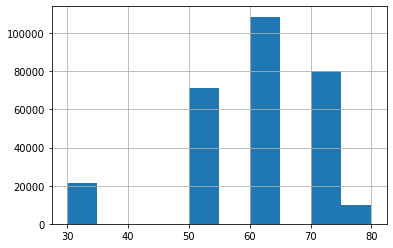

In [16]:
test['maximum_speed_limit'].hist()

In [17]:
test["maximum_speed_limit"].value_counts()

60.0    108606
70.0     80356
50.0     71315
30.0     21350
80.0      9614
Name: maximum_speed_limit, dtype: int64

<AxesSubplot:>

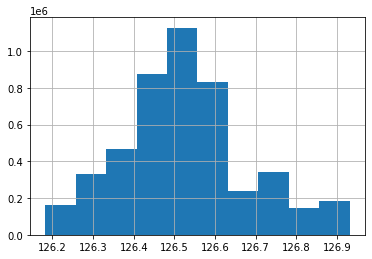

In [18]:
train['end_longitude'].hist()

In [26]:
print(len(train['end_longitude'].value_counts()))
print(train['end_longitude'].max())
train['end_longitude'].value_counts()

586
126.930940973848


126.567766    23126
126.736249    20791
126.456384    18168
126.505998    18126
126.556173    18083
              ...  
126.680766      881
126.678235      788
126.524331      744
126.524410      744
126.524429      587
Name: end_longitude, Length: 586, dtype: int64

In [29]:
len(train[train['end_longitude'] > test['end_longitude'].max()])

23465

<AxesSubplot:>

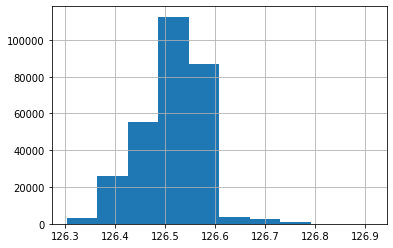

In [19]:
test['end_longitude'].hist()

In [25]:
print(len(test['end_longitude'].value_counts()))
print(test['end_longitude'].max())
test['end_longitude'].value_counts()

296
126.912947762086


126.567766    2709
126.456384    2220
126.556173    2215
126.505998    2214
126.509864    2195
              ... 
126.758749       7
126.758507       7
126.709277       7
126.842086       7
126.769650       7
Name: end_longitude, Length: 296, dtype: int64

In [44]:
train["multi_linked"].value_counts()

0    4698978
1       2239
Name: multi_linked, dtype: int64

In [45]:
test["multi_linked"].value_counts()

0    291241
Name: multi_linked, dtype: int64

In [54]:
train["connect_code"].value_counts()

0      4689075
103      12142
Name: connect_code, dtype: int64

In [55]:
test["connect_code"].value_counts()

0    291241
Name: connect_code, dtype: int64

In [60]:
train["start_latitude"].value_counts()

33.248633    23291
33.435941    20775
33.465863    18137
33.507349    18084
33.500330    18076
             ...  
33.491729      881
33.437249      788
33.256671      744
33.261270      744
33.257401      587
Name: start_latitude, Length: 586, dtype: int64

In [61]:
test["start_latitude"].value_counts()

33.248633    2747
33.465863    2217
33.507349    2215
33.500330    2210
33.249029    2190
             ... 
33.419828       7
33.420435       7
33.447183       7
33.341060       7
33.345240       7
Name: start_latitude, Length: 294, dtype: int64

- 제한속도별로 랜덤포레스트를 돌린후 다시합치는 계획 : 예시로 속도 80제한 데이터만 추출하여 랜덤포레스트 돌려본다.
- "maximum_speed_limit" 분리되면 사용되지 않으므로 레이블인코딩 제외

In [84]:
train = pd.read_parquet('./train.parquet')
test = pd.read_parquet('./test.parquet')
train = train.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)
test = test.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)

In [85]:
from sklearn.preprocessing import LabelEncoder
str_col = ["base_hour","day_of_week","lane_count","road_rating","multi_linked","connect_code"
           ,"weight_restricted","road_type","start_latitude","start_longitude","start_turn_restricted",
          "end_turn_restricted","road_name","start_node_name","end_node_name",'end_latitude','end_longitude'] # "maximum_speed_limit"
for i in str_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])
    
    for label in np.unique(test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])

In [86]:
train = train[train["maximum_speed_limit"]==70]
y_train = train['target'] 
X_train = train.drop(['id', 'target',"base_date"], axis=1)

test = test[test["maximum_speed_limit"]==70]
test_id = test['id']
test = test.drop(['id',"base_date"], axis=1)

print(X_train.shape)
print(y_train.shape)
print(test.shape)

(995077, 18)
(995077,)
(80356, 18)


In [48]:
prediction_table = pd.DataFrame(test_id)

In [87]:
X_train,X_test,y_train,y_test = train_test_split(
    X_train,y_train,test_size=0.2,random_state=10
)

In [88]:
from sklearn.ensemble import RandomForestRegressor
tp = RandomForestRegressor(random_state=10)
tp.fit(X_train,y_train)
pred = tp.predict(X_test)
mae = mean_absolute_error(pred,y_test)
print(mae)

3.7756478067256523


In [46]:
prediction_table['target'] = tp.predict(test)

In [47]:
prediction_table.to_csv('./target80.csv')

In [ ]:
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor


r1 = RandomForestRegressor(random_state=10,criterion='absolute_error')
r2 = CatBoostRegressor(random_state=10)
r3 = ExtraTreesRegressor(random_state=10,criterion='absolute_error')
vote = VotingRegressor([('r1', r1), ('r2', r2), ('r3', r3)])
vote.fit(X_train,y_train)

In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

def rf_speed(speed):
    train = pd.read_parquet('./train.parquet')
    test = pd.read_parquet('./test.parquet')
    train = train.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)
    test = test.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)
    
    str_col = ["base_hour","day_of_week","lane_count","road_rating","multi_linked","connect_code"
           ,"weight_restricted","road_type","start_latitude","start_longitude","start_turn_restricted",
          "end_turn_restricted","road_name","start_node_name","end_node_name",'end_latitude','end_longitude'] # "maximum_speed_limit"
    for i in str_col:
        le = LabelEncoder()
        le=le.fit(train[i])
        train[i]=le.transform(train[i])

        for label in np.unique(test[i]):
            if label not in le.classes_: 
                le.classes_ = np.append(le.classes_, label)
        test[i]=le.transform(test[i])
        
    train = train[train["maximum_speed_limit"]==speed]
    y_train = train['target'] 
    X_train = train.drop(['id', 'target',"base_date"], axis=1)

    test = test[test["maximum_speed_limit"]==speed]
    test_id = test['id']
    test = test.drop(['id',"base_date"], axis=1)
    
    prediction_table = pd.DataFrame(test_id)
    
    X_train,X_test,y_train,y_test = train_test_split(
        X_train,y_train,test_size=0.2,random_state=10
    )
    
    r1 = RandomForestRegressor(random_state=10)
#     r2 = CatBoostRegressor(random_state=10)
#     r3 = ExtraTreesRegressor(random_state=10)
#     vote = VotingRegressor([('r1', r1), ('r2', r2), ('r3', r3)])
    
#     parms = {'verbose':[True]}
#     grid_cv = GridSearchCV(vote,param_grid=parms,cv=5,n_jobs=-1,scoring='neg_mean_absolute_error')# ,param_grid=parms
#     grid_cv.fit(X_train,y_train)
    
    pred = r1.predict(X_test)
    mae = mean_absolute_error(pred,y_test)
    print(mae)
    
    prediction_table['target'] = grid_cv.predict(test)
    prediction_table.to_csv(f'./target{speed}.csv')
    print(f'save {speed}')

In [10]:
rf_speed(80)
rf_speed(70)
rf_speed(60)
rf_speed(50)
rf_speed(30) # voting 

[Voting] ....................... (1 of 3) Processing r1, total= 2.8min
Learning rate set to 0.111282
0:	learn: 12.6080286	total: 62ms	remaining: 1m 1s
1:	learn: 11.8449001	total: 92.7ms	remaining: 46.3s
2:	learn: 11.1785933	total: 124ms	remaining: 41.4s
3:	learn: 10.6207203	total: 164ms	remaining: 40.8s
4:	learn: 10.1372367	total: 193ms	remaining: 38.4s
5:	learn: 9.7169159	total: 224ms	remaining: 37.1s
6:	learn: 9.3653620	total: 254ms	remaining: 36.1s
7:	learn: 9.0694441	total: 285ms	remaining: 35.3s
8:	learn: 8.8253404	total: 314ms	remaining: 34.5s
9:	learn: 8.6178602	total: 343ms	remaining: 34s
10:	learn: 8.4158587	total: 376ms	remaining: 33.8s
11:	learn: 8.2388586	total: 406ms	remaining: 33.4s
12:	learn: 8.0899978	total: 435ms	remaining: 33s
13:	learn: 7.9641566	total: 466ms	remaining: 32.8s
14:	learn: 7.8437899	total: 497ms	remaining: 32.6s
15:	learn: 7.7316573	total: 533ms	remaining: 32.8s
16:	learn: 7.6245586	total: 564ms	remaining: 32.6s
17:	learn: 7.5317311	total: 594ms	remaini

162:	learn: 5.0742207	total: 4.55s	remaining: 23.3s
163:	learn: 5.0704441	total: 4.57s	remaining: 23.3s
164:	learn: 5.0663649	total: 4.6s	remaining: 23.3s
165:	learn: 5.0635651	total: 4.63s	remaining: 23.2s
166:	learn: 5.0600209	total: 4.65s	remaining: 23.2s
167:	learn: 5.0534241	total: 4.68s	remaining: 23.2s
168:	learn: 5.0506757	total: 4.71s	remaining: 23.2s
169:	learn: 5.0454697	total: 4.74s	remaining: 23.1s
170:	learn: 5.0396324	total: 4.76s	remaining: 23.1s
171:	learn: 5.0346265	total: 4.79s	remaining: 23.1s
172:	learn: 5.0322880	total: 4.82s	remaining: 23s
173:	learn: 5.0279656	total: 4.84s	remaining: 23s
174:	learn: 5.0235295	total: 4.87s	remaining: 23s
175:	learn: 5.0192197	total: 4.9s	remaining: 23s
176:	learn: 5.0166278	total: 4.93s	remaining: 22.9s
177:	learn: 5.0152034	total: 4.96s	remaining: 22.9s
178:	learn: 5.0080211	total: 4.99s	remaining: 22.9s
179:	learn: 5.0032076	total: 5.02s	remaining: 22.9s
180:	learn: 4.9979124	total: 5.05s	remaining: 22.8s
181:	learn: 4.9922433	

327:	learn: 4.6597933	total: 9.14s	remaining: 18.7s
328:	learn: 4.6586904	total: 9.17s	remaining: 18.7s
329:	learn: 4.6568755	total: 9.2s	remaining: 18.7s
330:	learn: 4.6560548	total: 9.22s	remaining: 18.6s
331:	learn: 4.6530777	total: 9.25s	remaining: 18.6s
332:	learn: 4.6517112	total: 9.28s	remaining: 18.6s
333:	learn: 4.6494504	total: 9.31s	remaining: 18.6s
334:	learn: 4.6486165	total: 9.33s	remaining: 18.5s
335:	learn: 4.6474969	total: 9.36s	remaining: 18.5s
336:	learn: 4.6455085	total: 9.39s	remaining: 18.5s
337:	learn: 4.6444142	total: 9.41s	remaining: 18.4s
338:	learn: 4.6434768	total: 9.44s	remaining: 18.4s
339:	learn: 4.6421304	total: 9.47s	remaining: 18.4s
340:	learn: 4.6411270	total: 9.5s	remaining: 18.4s
341:	learn: 4.6395855	total: 9.52s	remaining: 18.3s
342:	learn: 4.6381815	total: 9.55s	remaining: 18.3s
343:	learn: 4.6376599	total: 9.57s	remaining: 18.3s
344:	learn: 4.6362072	total: 9.6s	remaining: 18.2s
345:	learn: 4.6355262	total: 9.62s	remaining: 18.2s
346:	learn: 4.6

494:	learn: 4.4803326	total: 13.8s	remaining: 14.1s
495:	learn: 4.4800453	total: 13.8s	remaining: 14s
496:	learn: 4.4783185	total: 13.9s	remaining: 14s
497:	learn: 4.4777781	total: 13.9s	remaining: 14s
498:	learn: 4.4772817	total: 13.9s	remaining: 14s
499:	learn: 4.4766106	total: 13.9s	remaining: 13.9s
500:	learn: 4.4760366	total: 14s	remaining: 13.9s
501:	learn: 4.4747613	total: 14s	remaining: 13.9s
502:	learn: 4.4741200	total: 14s	remaining: 13.8s
503:	learn: 4.4734462	total: 14s	remaining: 13.8s
504:	learn: 4.4730610	total: 14.1s	remaining: 13.8s
505:	learn: 4.4722616	total: 14.1s	remaining: 13.8s
506:	learn: 4.4715567	total: 14.1s	remaining: 13.7s
507:	learn: 4.4711677	total: 14.1s	remaining: 13.7s
508:	learn: 4.4707232	total: 14.2s	remaining: 13.7s
509:	learn: 4.4700600	total: 14.2s	remaining: 13.6s
510:	learn: 4.4693575	total: 14.2s	remaining: 13.6s
511:	learn: 4.4687242	total: 14.2s	remaining: 13.6s
512:	learn: 4.4672851	total: 14.3s	remaining: 13.5s
513:	learn: 4.4665208	total:

659:	learn: 4.3817542	total: 18.4s	remaining: 9.49s
660:	learn: 4.3812733	total: 18.5s	remaining: 9.46s
661:	learn: 4.3809656	total: 18.5s	remaining: 9.44s
662:	learn: 4.3804924	total: 18.5s	remaining: 9.41s
663:	learn: 4.3801440	total: 18.5s	remaining: 9.38s
664:	learn: 4.3798693	total: 18.6s	remaining: 9.35s
665:	learn: 4.3795707	total: 18.6s	remaining: 9.33s
666:	learn: 4.3784318	total: 18.6s	remaining: 9.3s
667:	learn: 4.3780847	total: 18.7s	remaining: 9.27s
668:	learn: 4.3777978	total: 18.7s	remaining: 9.25s
669:	learn: 4.3774602	total: 18.7s	remaining: 9.22s
670:	learn: 4.3769229	total: 18.7s	remaining: 9.19s
671:	learn: 4.3766204	total: 18.8s	remaining: 9.16s
672:	learn: 4.3760294	total: 18.8s	remaining: 9.13s
673:	learn: 4.3756847	total: 18.8s	remaining: 9.11s
674:	learn: 4.3753237	total: 18.9s	remaining: 9.08s
675:	learn: 4.3749225	total: 18.9s	remaining: 9.05s
676:	learn: 4.3744701	total: 18.9s	remaining: 9.02s
677:	learn: 4.3741185	total: 18.9s	remaining: 8.99s
678:	learn: 4

821:	learn: 4.3153094	total: 23s	remaining: 4.98s
822:	learn: 4.3150937	total: 23s	remaining: 4.96s
823:	learn: 4.3146862	total: 23.1s	remaining: 4.93s
824:	learn: 4.3144296	total: 23.1s	remaining: 4.9s
825:	learn: 4.3141472	total: 23.1s	remaining: 4.87s
826:	learn: 4.3139386	total: 23.1s	remaining: 4.84s
827:	learn: 4.3136485	total: 23.2s	remaining: 4.81s
828:	learn: 4.3135451	total: 23.2s	remaining: 4.79s
829:	learn: 4.3131885	total: 23.2s	remaining: 4.76s
830:	learn: 4.3128865	total: 23.3s	remaining: 4.73s
831:	learn: 4.3125784	total: 23.3s	remaining: 4.7s
832:	learn: 4.3123922	total: 23.3s	remaining: 4.67s
833:	learn: 4.3116074	total: 23.3s	remaining: 4.64s
834:	learn: 4.3112843	total: 23.4s	remaining: 4.62s
835:	learn: 4.3110657	total: 23.4s	remaining: 4.59s
836:	learn: 4.3108341	total: 23.4s	remaining: 4.56s
837:	learn: 4.3106172	total: 23.4s	remaining: 4.53s
838:	learn: 4.3104527	total: 23.5s	remaining: 4.5s
839:	learn: 4.3100200	total: 23.5s	remaining: 4.47s
840:	learn: 4.30970

980:	learn: 4.2676824	total: 27.4s	remaining: 531ms
981:	learn: 4.2674137	total: 27.5s	remaining: 503ms
982:	learn: 4.2671711	total: 27.5s	remaining: 475ms
983:	learn: 4.2667175	total: 27.5s	remaining: 447ms
984:	learn: 4.2664254	total: 27.5s	remaining: 419ms
985:	learn: 4.2661619	total: 27.6s	remaining: 391ms
986:	learn: 4.2659480	total: 27.6s	remaining: 363ms
987:	learn: 4.2655419	total: 27.6s	remaining: 335ms
988:	learn: 4.2654183	total: 27.6s	remaining: 307ms
989:	learn: 4.2652226	total: 27.7s	remaining: 279ms
990:	learn: 4.2649427	total: 27.7s	remaining: 252ms
991:	learn: 4.2647634	total: 27.7s	remaining: 224ms
992:	learn: 4.2646199	total: 27.7s	remaining: 196ms
993:	learn: 4.2643971	total: 27.8s	remaining: 168ms
994:	learn: 4.2641547	total: 27.8s	remaining: 140ms
995:	learn: 4.2638741	total: 27.8s	remaining: 112ms
996:	learn: 4.2635914	total: 27.9s	remaining: 83.8ms
997:	learn: 4.2633026	total: 27.9s	remaining: 55.9ms
998:	learn: 4.2630671	total: 27.9s	remaining: 27.9ms
999:	lear

C:\Users\User\anaconda3\envs\git_repo\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
2 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\git_repo\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\envs\git_repo\lib\site-packages\sklearn\ensemble\_voting.py", line 601, in fit
    return super().fit(X, y, sample_weight)
  File "C:\Users\User\anaconda3\envs\git_repo\lib\site-packages\sklearn\ensemble\_voting.py", line 83, in fit
    self.estimators_ =

[Voting] ....................... (1 of 3) Processing r1, total= 4.3min
Learning rate set to 0.117633
0:	learn: 13.9416514	total: 60ms	remaining: 60s
1:	learn: 13.0835137	total: 100ms	remaining: 50s
2:	learn: 12.3136203	total: 142ms	remaining: 47.1s
3:	learn: 11.7127576	total: 182ms	remaining: 45.4s
4:	learn: 11.2011322	total: 224ms	remaining: 44.6s
5:	learn: 10.7440030	total: 275ms	remaining: 45.6s
6:	learn: 10.3531432	total: 315ms	remaining: 44.7s
7:	learn: 10.0442699	total: 354ms	remaining: 43.9s
8:	learn: 9.7624382	total: 395ms	remaining: 43.5s
9:	learn: 9.4947174	total: 434ms	remaining: 43s
10:	learn: 9.2665196	total: 472ms	remaining: 42.4s
11:	learn: 9.0640552	total: 510ms	remaining: 42s
12:	learn: 8.9054227	total: 543ms	remaining: 41.3s
13:	learn: 8.7603432	total: 581ms	remaining: 40.9s
14:	learn: 8.5933453	total: 617ms	remaining: 40.5s
15:	learn: 8.4708185	total: 655ms	remaining: 40.3s
16:	learn: 8.3576921	total: 691ms	remaining: 40s
17:	learn: 8.2571063	total: 728ms	remaining: 

163:	learn: 5.7043209	total: 6.33s	remaining: 32.3s
164:	learn: 5.6996325	total: 6.37s	remaining: 32.2s
165:	learn: 5.6954091	total: 6.41s	remaining: 32.2s
166:	learn: 5.6925631	total: 6.44s	remaining: 32.1s
167:	learn: 5.6887888	total: 6.48s	remaining: 32.1s
168:	learn: 5.6778335	total: 6.51s	remaining: 32s
169:	learn: 5.6738867	total: 6.55s	remaining: 32s
170:	learn: 5.6663120	total: 6.59s	remaining: 31.9s
171:	learn: 5.6640775	total: 6.63s	remaining: 31.9s
172:	learn: 5.6600055	total: 6.67s	remaining: 31.9s
173:	learn: 5.6542459	total: 6.71s	remaining: 31.8s
174:	learn: 5.6507572	total: 6.74s	remaining: 31.8s
175:	learn: 5.6428446	total: 6.78s	remaining: 31.7s
176:	learn: 5.6352267	total: 6.81s	remaining: 31.7s
177:	learn: 5.6312051	total: 6.85s	remaining: 31.6s
178:	learn: 5.6263686	total: 6.89s	remaining: 31.6s
179:	learn: 5.6230535	total: 6.93s	remaining: 31.6s
180:	learn: 5.6196028	total: 6.97s	remaining: 31.5s
181:	learn: 5.6130377	total: 7.02s	remaining: 31.5s
182:	learn: 5.60

324:	learn: 5.2376949	total: 12.5s	remaining: 26s
325:	learn: 5.2354070	total: 12.6s	remaining: 26s
326:	learn: 5.2334774	total: 12.6s	remaining: 26s
327:	learn: 5.2318133	total: 12.6s	remaining: 25.9s
328:	learn: 5.2292404	total: 12.7s	remaining: 25.9s
329:	learn: 5.2279665	total: 12.7s	remaining: 25.8s
330:	learn: 5.2256028	total: 12.8s	remaining: 25.8s
331:	learn: 5.2238987	total: 12.8s	remaining: 25.7s
332:	learn: 5.2221111	total: 12.8s	remaining: 25.7s
333:	learn: 5.2204368	total: 12.9s	remaining: 25.7s
334:	learn: 5.2180438	total: 12.9s	remaining: 25.6s
335:	learn: 5.2166117	total: 12.9s	remaining: 25.6s
336:	learn: 5.2148386	total: 13s	remaining: 25.6s
337:	learn: 5.2133099	total: 13s	remaining: 25.5s
338:	learn: 5.2128292	total: 13.1s	remaining: 25.5s
339:	learn: 5.2119050	total: 13.1s	remaining: 25.4s
340:	learn: 5.2106426	total: 13.1s	remaining: 25.4s
341:	learn: 5.2089753	total: 13.2s	remaining: 25.4s
342:	learn: 5.2080401	total: 13.2s	remaining: 25.3s
343:	learn: 5.2069952	

484:	learn: 5.0485852	total: 18.8s	remaining: 19.9s
485:	learn: 5.0482817	total: 18.8s	remaining: 19.9s
486:	learn: 5.0471193	total: 18.8s	remaining: 19.8s
487:	learn: 5.0463076	total: 18.9s	remaining: 19.8s
488:	learn: 5.0456900	total: 18.9s	remaining: 19.8s
489:	learn: 5.0443984	total: 19s	remaining: 19.7s
490:	learn: 5.0439592	total: 19s	remaining: 19.7s
491:	learn: 5.0425495	total: 19s	remaining: 19.7s
492:	learn: 5.0419160	total: 19.1s	remaining: 19.6s
493:	learn: 5.0407552	total: 19.1s	remaining: 19.6s
494:	learn: 5.0399033	total: 19.1s	remaining: 19.5s
495:	learn: 5.0394953	total: 19.2s	remaining: 19.5s
496:	learn: 5.0386771	total: 19.2s	remaining: 19.5s
497:	learn: 5.0380545	total: 19.3s	remaining: 19.4s
498:	learn: 5.0368573	total: 19.3s	remaining: 19.4s
499:	learn: 5.0361579	total: 19.3s	remaining: 19.3s
500:	learn: 5.0349826	total: 19.4s	remaining: 19.3s
501:	learn: 5.0342112	total: 19.4s	remaining: 19.3s
502:	learn: 5.0337419	total: 19.5s	remaining: 19.2s
503:	learn: 5.0329

644:	learn: 4.9433921	total: 25s	remaining: 13.7s
645:	learn: 4.9428865	total: 25s	remaining: 13.7s
646:	learn: 4.9420736	total: 25s	remaining: 13.7s
647:	learn: 4.9412149	total: 25.1s	remaining: 13.6s
648:	learn: 4.9407397	total: 25.1s	remaining: 13.6s
649:	learn: 4.9404963	total: 25.2s	remaining: 13.5s
650:	learn: 4.9399566	total: 25.2s	remaining: 13.5s
651:	learn: 4.9395670	total: 25.2s	remaining: 13.5s
652:	learn: 4.9392647	total: 25.3s	remaining: 13.4s
653:	learn: 4.9387117	total: 25.3s	remaining: 13.4s
654:	learn: 4.9376724	total: 25.4s	remaining: 13.4s
655:	learn: 4.9367951	total: 25.4s	remaining: 13.3s
656:	learn: 4.9361893	total: 25.4s	remaining: 13.3s
657:	learn: 4.9357642	total: 25.5s	remaining: 13.2s
658:	learn: 4.9354058	total: 25.5s	remaining: 13.2s
659:	learn: 4.9351448	total: 25.5s	remaining: 13.2s
660:	learn: 4.9347907	total: 25.6s	remaining: 13.1s
661:	learn: 4.9341877	total: 25.6s	remaining: 13.1s
662:	learn: 4.9335733	total: 25.7s	remaining: 13s
663:	learn: 4.932806

804:	learn: 4.8738638	total: 31.2s	remaining: 7.55s
805:	learn: 4.8736379	total: 31.2s	remaining: 7.52s
806:	learn: 4.8733372	total: 31.3s	remaining: 7.48s
807:	learn: 4.8729280	total: 31.3s	remaining: 7.44s
808:	learn: 4.8726314	total: 31.3s	remaining: 7.4s
809:	learn: 4.8724559	total: 31.4s	remaining: 7.36s
810:	learn: 4.8721430	total: 31.4s	remaining: 7.32s
811:	learn: 4.8713795	total: 31.5s	remaining: 7.29s
812:	learn: 4.8710204	total: 31.5s	remaining: 7.25s
813:	learn: 4.8704900	total: 31.6s	remaining: 7.21s
814:	learn: 4.8695596	total: 31.6s	remaining: 7.17s
815:	learn: 4.8692930	total: 31.6s	remaining: 7.13s
816:	learn: 4.8690876	total: 31.7s	remaining: 7.09s
817:	learn: 4.8686893	total: 31.7s	remaining: 7.05s
818:	learn: 4.8685197	total: 31.7s	remaining: 7.02s
819:	learn: 4.8681862	total: 31.8s	remaining: 6.98s
820:	learn: 4.8679009	total: 31.8s	remaining: 6.94s
821:	learn: 4.8674991	total: 31.9s	remaining: 6.91s
822:	learn: 4.8668158	total: 31.9s	remaining: 6.87s
823:	learn: 4

964:	learn: 4.8207769	total: 37.4s	remaining: 1.36s
965:	learn: 4.8206137	total: 37.5s	remaining: 1.32s
966:	learn: 4.8203218	total: 37.5s	remaining: 1.28s
967:	learn: 4.8198284	total: 37.6s	remaining: 1.24s
968:	learn: 4.8195417	total: 37.6s	remaining: 1.2s
969:	learn: 4.8192945	total: 37.6s	remaining: 1.16s
970:	learn: 4.8191217	total: 37.7s	remaining: 1.13s
971:	learn: 4.8189267	total: 37.7s	remaining: 1.09s
972:	learn: 4.8187304	total: 37.8s	remaining: 1.05s
973:	learn: 4.8184558	total: 37.8s	remaining: 1.01s
974:	learn: 4.8179419	total: 37.8s	remaining: 970ms
975:	learn: 4.8177420	total: 37.9s	remaining: 932ms
976:	learn: 4.8171758	total: 37.9s	remaining: 893ms
977:	learn: 4.8170617	total: 38s	remaining: 854ms
978:	learn: 4.8168906	total: 38s	remaining: 815ms
979:	learn: 4.8164796	total: 38s	remaining: 776ms
980:	learn: 4.8159231	total: 38.1s	remaining: 738ms
981:	learn: 4.8154230	total: 38.1s	remaining: 699ms
982:	learn: 4.8152396	total: 38.2s	remaining: 660ms
983:	learn: 4.81500

C:\Users\User\anaconda3\envs\git_repo\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
3 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\git_repo\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\envs\git_repo\lib\site-packages\sklearn\ensemble\_voting.py", line 601, in fit
    return super().fit(X, y, sample_weight)
  File "C:\Users\User\anaconda3\envs\git_repo\lib\site-packages\sklearn\ensemble\_voting.py", line 83, in fit
    self.estimators_ =

[Voting] ....................... (1 of 3) Processing r1, total= 9.0min
Learning rate set to 0.127607
0:	learn: 13.0876735	total: 82ms	remaining: 1m 21s
1:	learn: 12.2314732	total: 149ms	remaining: 1m 14s
2:	learn: 11.5015306	total: 212ms	remaining: 1m 10s
3:	learn: 10.8467961	total: 277ms	remaining: 1m 8s
4:	learn: 10.3577896	total: 337ms	remaining: 1m 6s
5:	learn: 9.9561412	total: 402ms	remaining: 1m 6s
6:	learn: 9.5409795	total: 468ms	remaining: 1m 6s
7:	learn: 9.2588413	total: 531ms	remaining: 1m 5s
8:	learn: 9.0209106	total: 593ms	remaining: 1m 5s
9:	learn: 8.7771828	total: 662ms	remaining: 1m 5s
10:	learn: 8.5870046	total: 726ms	remaining: 1m 5s
11:	learn: 8.4117938	total: 791ms	remaining: 1m 5s
12:	learn: 8.2609417	total: 852ms	remaining: 1m 4s
13:	learn: 8.1349622	total: 916ms	remaining: 1m 4s
14:	learn: 8.0023087	total: 977ms	remaining: 1m 4s
15:	learn: 7.9131502	total: 1.03s	remaining: 1m 3s
16:	learn: 7.7988782	total: 1.09s	remaining: 1m 3s
17:	learn: 7.6742869	total: 1.17s	r

161:	learn: 5.3815991	total: 10s	remaining: 51.8s
162:	learn: 5.3755450	total: 10.1s	remaining: 51.7s
163:	learn: 5.3734395	total: 10.1s	remaining: 51.6s
164:	learn: 5.3698049	total: 10.2s	remaining: 51.6s
165:	learn: 5.3662639	total: 10.2s	remaining: 51.5s
166:	learn: 5.3633013	total: 10.3s	remaining: 51.4s
167:	learn: 5.3613431	total: 10.4s	remaining: 51.4s
168:	learn: 5.3555755	total: 10.4s	remaining: 51.3s
169:	learn: 5.3521758	total: 10.5s	remaining: 51.3s
170:	learn: 5.3480072	total: 10.6s	remaining: 51.3s
171:	learn: 5.3457632	total: 10.6s	remaining: 51.2s
172:	learn: 5.3419904	total: 10.7s	remaining: 51.2s
173:	learn: 5.3383898	total: 10.8s	remaining: 51.3s
174:	learn: 5.3313677	total: 10.9s	remaining: 51.2s
175:	learn: 5.3279780	total: 10.9s	remaining: 51.1s
176:	learn: 5.3252189	total: 11s	remaining: 51.1s
177:	learn: 5.3222355	total: 11.1s	remaining: 51.1s
178:	learn: 5.3201544	total: 11.1s	remaining: 51s
179:	learn: 5.3155252	total: 11.2s	remaining: 51s
180:	learn: 5.313230

321:	learn: 4.9854636	total: 20.1s	remaining: 42.3s
322:	learn: 4.9843443	total: 20.1s	remaining: 42.2s
323:	learn: 4.9826152	total: 20.2s	remaining: 42.2s
324:	learn: 4.9816337	total: 20.3s	remaining: 42.1s
325:	learn: 4.9804708	total: 20.4s	remaining: 42.1s
326:	learn: 4.9795635	total: 20.4s	remaining: 42s
327:	learn: 4.9786714	total: 20.5s	remaining: 41.9s
328:	learn: 4.9771212	total: 20.5s	remaining: 41.9s
329:	learn: 4.9752530	total: 20.6s	remaining: 41.8s
330:	learn: 4.9744988	total: 20.7s	remaining: 41.7s
331:	learn: 4.9729159	total: 20.7s	remaining: 41.7s
332:	learn: 4.9720457	total: 20.8s	remaining: 41.6s
333:	learn: 4.9705300	total: 20.8s	remaining: 41.5s
334:	learn: 4.9681688	total: 20.9s	remaining: 41.5s
335:	learn: 4.9675527	total: 21s	remaining: 41.4s
336:	learn: 4.9658106	total: 21s	remaining: 41.4s
337:	learn: 4.9644803	total: 21.1s	remaining: 41.3s
338:	learn: 4.9627264	total: 21.1s	remaining: 41.2s
339:	learn: 4.9614277	total: 21.2s	remaining: 41.2s
340:	learn: 4.9599

483:	learn: 4.8194588	total: 30.3s	remaining: 32.3s
484:	learn: 4.8188945	total: 30.3s	remaining: 32.2s
485:	learn: 4.8175503	total: 30.4s	remaining: 32.1s
486:	learn: 4.8170521	total: 30.4s	remaining: 32.1s
487:	learn: 4.8163904	total: 30.5s	remaining: 32s
488:	learn: 4.8157587	total: 30.6s	remaining: 32s
489:	learn: 4.8148108	total: 30.6s	remaining: 31.9s
490:	learn: 4.8139307	total: 30.7s	remaining: 31.8s
491:	learn: 4.8135501	total: 30.8s	remaining: 31.8s
492:	learn: 4.8132799	total: 30.8s	remaining: 31.7s
493:	learn: 4.8121672	total: 30.9s	remaining: 31.6s
494:	learn: 4.8108983	total: 31s	remaining: 31.6s
495:	learn: 4.8102076	total: 31s	remaining: 31.5s
496:	learn: 4.8094382	total: 31.1s	remaining: 31.5s
497:	learn: 4.8086816	total: 31.1s	remaining: 31.4s
498:	learn: 4.8076523	total: 31.2s	remaining: 31.3s
499:	learn: 4.8071510	total: 31.3s	remaining: 31.3s
500:	learn: 4.8065880	total: 31.3s	remaining: 31.2s
501:	learn: 4.8057245	total: 31.4s	remaining: 31.2s
502:	learn: 4.804890

644:	learn: 4.7252484	total: 40.5s	remaining: 22.3s
645:	learn: 4.7248134	total: 40.6s	remaining: 22.2s
646:	learn: 4.7243568	total: 40.6s	remaining: 22.2s
647:	learn: 4.7239965	total: 40.7s	remaining: 22.1s
648:	learn: 4.7234802	total: 40.7s	remaining: 22s
649:	learn: 4.7231572	total: 40.8s	remaining: 22s
650:	learn: 4.7227275	total: 40.9s	remaining: 21.9s
651:	learn: 4.7221740	total: 40.9s	remaining: 21.8s
652:	learn: 4.7218818	total: 41s	remaining: 21.8s
653:	learn: 4.7216329	total: 41.1s	remaining: 21.7s
654:	learn: 4.7212875	total: 41.1s	remaining: 21.7s
655:	learn: 4.7207276	total: 41.2s	remaining: 21.6s
656:	learn: 4.7203660	total: 41.3s	remaining: 21.5s
657:	learn: 4.7200623	total: 41.3s	remaining: 21.5s
658:	learn: 4.7196343	total: 41.4s	remaining: 21.4s
659:	learn: 4.7190652	total: 41.5s	remaining: 21.4s
660:	learn: 4.7187158	total: 41.5s	remaining: 21.3s
661:	learn: 4.7183638	total: 41.6s	remaining: 21.2s
662:	learn: 4.7180074	total: 41.6s	remaining: 21.2s
663:	learn: 4.7177

806:	learn: 4.6653768	total: 51.1s	remaining: 12.2s
807:	learn: 4.6651250	total: 51.1s	remaining: 12.1s
808:	learn: 4.6647683	total: 51.2s	remaining: 12.1s
809:	learn: 4.6643653	total: 51.3s	remaining: 12s
810:	learn: 4.6641190	total: 51.3s	remaining: 12s
811:	learn: 4.6637976	total: 51.4s	remaining: 11.9s
812:	learn: 4.6634164	total: 51.5s	remaining: 11.8s
813:	learn: 4.6628778	total: 51.5s	remaining: 11.8s
814:	learn: 4.6625772	total: 51.6s	remaining: 11.7s
815:	learn: 4.6621998	total: 51.7s	remaining: 11.6s
816:	learn: 4.6619076	total: 51.7s	remaining: 11.6s
817:	learn: 4.6615600	total: 51.8s	remaining: 11.5s
818:	learn: 4.6611272	total: 51.9s	remaining: 11.5s
819:	learn: 4.6608833	total: 51.9s	remaining: 11.4s
820:	learn: 4.6606600	total: 52s	remaining: 11.3s
821:	learn: 4.6604031	total: 52.1s	remaining: 11.3s
822:	learn: 4.6600097	total: 52.1s	remaining: 11.2s
823:	learn: 4.6597867	total: 52.2s	remaining: 11.2s
824:	learn: 4.6595108	total: 52.3s	remaining: 11.1s
825:	learn: 4.6591

968:	learn: 4.6205998	total: 1m 1s	remaining: 1.98s
969:	learn: 4.6204083	total: 1m 1s	remaining: 1.92s
970:	learn: 4.6201331	total: 1m 1s	remaining: 1.85s
971:	learn: 4.6198963	total: 1m 2s	remaining: 1.79s
972:	learn: 4.6196739	total: 1m 2s	remaining: 1.72s
973:	learn: 4.6194862	total: 1m 2s	remaining: 1.66s
974:	learn: 4.6192602	total: 1m 2s	remaining: 1.6s
975:	learn: 4.6190579	total: 1m 2s	remaining: 1.53s
976:	learn: 4.6189510	total: 1m 2s	remaining: 1.47s
977:	learn: 4.6187163	total: 1m 2s	remaining: 1.41s
978:	learn: 4.6184850	total: 1m 2s	remaining: 1.34s
979:	learn: 4.6181968	total: 1m 2s	remaining: 1.28s
980:	learn: 4.6178825	total: 1m 2s	remaining: 1.21s
981:	learn: 4.6177607	total: 1m 2s	remaining: 1.15s
982:	learn: 4.6174108	total: 1m 2s	remaining: 1.09s
983:	learn: 4.6171045	total: 1m 2s	remaining: 1.02s
984:	learn: 4.6167586	total: 1m 2s	remaining: 959ms
985:	learn: 4.6165543	total: 1m 3s	remaining: 895ms
986:	learn: 4.6163418	total: 1m 3s	remaining: 831ms
987:	learn: 4

C:\Users\User\anaconda3\envs\git_repo\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
2 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\git_repo\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\envs\git_repo\lib\site-packages\sklearn\ensemble\_voting.py", line 601, in fit
    return super().fit(X, y, sample_weight)
  File "C:\Users\User\anaconda3\envs\git_repo\lib\site-packages\sklearn\ensemble\_voting.py", line 83, in fit
    self.estimators_ =

[Voting] ....................... (1 of 3) Processing r1, total= 4.9min
Learning rate set to 0.119574
0:	learn: 12.0303601	total: 71.2ms	remaining: 1m 11s
1:	learn: 11.4709708	total: 127ms	remaining: 1m 3s
2:	learn: 10.9301801	total: 173ms	remaining: 57.5s
3:	learn: 10.4836703	total: 216ms	remaining: 53.8s
4:	learn: 10.1255997	total: 258ms	remaining: 51.3s
5:	learn: 9.7364319	total: 305ms	remaining: 50.5s
6:	learn: 9.4346072	total: 352ms	remaining: 49.9s
7:	learn: 9.0697206	total: 396ms	remaining: 49.2s
8:	learn: 8.8352593	total: 442ms	remaining: 48.6s
9:	learn: 8.5904304	total: 486ms	remaining: 48.1s
10:	learn: 8.4426949	total: 525ms	remaining: 47.2s
11:	learn: 8.2554176	total: 571ms	remaining: 47s
12:	learn: 8.1312403	total: 614ms	remaining: 46.6s
13:	learn: 8.0207876	total: 653ms	remaining: 46s
14:	learn: 7.9325149	total: 695ms	remaining: 45.6s
15:	learn: 7.8527707	total: 736ms	remaining: 45.3s
16:	learn: 7.7475978	total: 792ms	remaining: 45.8s
17:	learn: 7.6095331	total: 838ms	remai

163:	learn: 5.2255499	total: 7.21s	remaining: 36.8s
164:	learn: 5.2211878	total: 7.25s	remaining: 36.7s
165:	learn: 5.2148547	total: 7.29s	remaining: 36.7s
166:	learn: 5.2092518	total: 7.34s	remaining: 36.6s
167:	learn: 5.2047743	total: 7.38s	remaining: 36.6s
168:	learn: 5.1998055	total: 7.43s	remaining: 36.5s
169:	learn: 5.1971932	total: 7.47s	remaining: 36.5s
170:	learn: 5.1940084	total: 7.52s	remaining: 36.4s
171:	learn: 5.1884969	total: 7.56s	remaining: 36.4s
172:	learn: 5.1853292	total: 7.6s	remaining: 36.3s
173:	learn: 5.1801906	total: 7.64s	remaining: 36.3s
174:	learn: 5.1767894	total: 7.68s	remaining: 36.2s
175:	learn: 5.1724008	total: 7.73s	remaining: 36.2s
176:	learn: 5.1696136	total: 7.77s	remaining: 36.1s
177:	learn: 5.1652063	total: 7.81s	remaining: 36.1s
178:	learn: 5.1626130	total: 7.85s	remaining: 36s
179:	learn: 5.1585841	total: 7.89s	remaining: 36s
180:	learn: 5.1538905	total: 7.94s	remaining: 35.9s
181:	learn: 5.1502225	total: 7.99s	remaining: 35.9s
182:	learn: 5.144

325:	learn: 4.8621966	total: 14.1s	remaining: 29.1s
326:	learn: 4.8610544	total: 14.1s	remaining: 29s
327:	learn: 4.8605009	total: 14.2s	remaining: 29s
328:	learn: 4.8597170	total: 14.2s	remaining: 28.9s
329:	learn: 4.8580771	total: 14.2s	remaining: 28.9s
330:	learn: 4.8566968	total: 14.3s	remaining: 28.8s
331:	learn: 4.8557885	total: 14.3s	remaining: 28.8s
332:	learn: 4.8550280	total: 14.3s	remaining: 28.7s
333:	learn: 4.8540815	total: 14.4s	remaining: 28.7s
334:	learn: 4.8529516	total: 14.4s	remaining: 28.7s
335:	learn: 4.8522033	total: 14.5s	remaining: 28.6s
336:	learn: 4.8513403	total: 14.5s	remaining: 28.6s
337:	learn: 4.8494542	total: 14.6s	remaining: 28.5s
338:	learn: 4.8484634	total: 14.6s	remaining: 28.5s
339:	learn: 4.8475349	total: 14.6s	remaining: 28.4s
340:	learn: 4.8470078	total: 14.7s	remaining: 28.4s
341:	learn: 4.8450443	total: 14.7s	remaining: 28.3s
342:	learn: 4.8444663	total: 14.8s	remaining: 28.3s
343:	learn: 4.8438364	total: 14.8s	remaining: 28.2s
344:	learn: 4.84

486:	learn: 4.7198587	total: 20.8s	remaining: 21.9s
487:	learn: 4.7188559	total: 20.9s	remaining: 21.9s
488:	learn: 4.7181494	total: 20.9s	remaining: 21.9s
489:	learn: 4.7169265	total: 21s	remaining: 21.8s
490:	learn: 4.7164200	total: 21s	remaining: 21.8s
491:	learn: 4.7157465	total: 21s	remaining: 21.7s
492:	learn: 4.7150365	total: 21.1s	remaining: 21.7s
493:	learn: 4.7144720	total: 21.1s	remaining: 21.6s
494:	learn: 4.7140444	total: 21.2s	remaining: 21.6s
495:	learn: 4.7129428	total: 21.2s	remaining: 21.6s
496:	learn: 4.7121959	total: 21.3s	remaining: 21.5s
497:	learn: 4.7111626	total: 21.3s	remaining: 21.5s
498:	learn: 4.7104050	total: 21.4s	remaining: 21.4s
499:	learn: 4.7096539	total: 21.4s	remaining: 21.4s
500:	learn: 4.7088651	total: 21.4s	remaining: 21.4s
501:	learn: 4.7083967	total: 21.5s	remaining: 21.3s
502:	learn: 4.7078240	total: 21.5s	remaining: 21.3s
503:	learn: 4.7073498	total: 21.6s	remaining: 21.2s
504:	learn: 4.7069946	total: 21.6s	remaining: 21.2s
505:	learn: 4.7064

649:	learn: 4.6386095	total: 27.8s	remaining: 15s
650:	learn: 4.6382043	total: 27.9s	remaining: 14.9s
651:	learn: 4.6379422	total: 27.9s	remaining: 14.9s
652:	learn: 4.6376282	total: 27.9s	remaining: 14.8s
653:	learn: 4.6373938	total: 28s	remaining: 14.8s
654:	learn: 4.6371384	total: 28s	remaining: 14.8s
655:	learn: 4.6366762	total: 28.1s	remaining: 14.7s
656:	learn: 4.6364674	total: 28.1s	remaining: 14.7s
657:	learn: 4.6361417	total: 28.2s	remaining: 14.6s
658:	learn: 4.6356220	total: 28.2s	remaining: 14.6s
659:	learn: 4.6351455	total: 28.2s	remaining: 14.5s
660:	learn: 4.6349695	total: 28.3s	remaining: 14.5s
661:	learn: 4.6345532	total: 28.3s	remaining: 14.5s
662:	learn: 4.6342862	total: 28.4s	remaining: 14.4s
663:	learn: 4.6338692	total: 28.4s	remaining: 14.4s
664:	learn: 4.6326479	total: 28.4s	remaining: 14.3s
665:	learn: 4.6322787	total: 28.5s	remaining: 14.3s
666:	learn: 4.6319050	total: 28.5s	remaining: 14.2s
667:	learn: 4.6314335	total: 28.6s	remaining: 14.2s
668:	learn: 4.6311

812:	learn: 4.5894383	total: 34.7s	remaining: 7.99s
813:	learn: 4.5891838	total: 34.8s	remaining: 7.94s
814:	learn: 4.5889895	total: 34.8s	remaining: 7.9s
815:	learn: 4.5887234	total: 34.8s	remaining: 7.86s
816:	learn: 4.5885175	total: 34.9s	remaining: 7.81s
817:	learn: 4.5883192	total: 34.9s	remaining: 7.77s
818:	learn: 4.5880742	total: 35s	remaining: 7.73s
819:	learn: 4.5877460	total: 35s	remaining: 7.69s
820:	learn: 4.5873947	total: 35.1s	remaining: 7.64s
821:	learn: 4.5870949	total: 35.1s	remaining: 7.6s
822:	learn: 4.5868684	total: 35.2s	remaining: 7.56s
823:	learn: 4.5866562	total: 35.2s	remaining: 7.52s
824:	learn: 4.5862979	total: 35.2s	remaining: 7.48s
825:	learn: 4.5860167	total: 35.3s	remaining: 7.43s
826:	learn: 4.5858786	total: 35.3s	remaining: 7.39s
827:	learn: 4.5855785	total: 35.4s	remaining: 7.35s
828:	learn: 4.5854730	total: 35.4s	remaining: 7.3s
829:	learn: 4.5852253	total: 35.5s	remaining: 7.26s
830:	learn: 4.5850883	total: 35.5s	remaining: 7.22s
831:	learn: 4.58491

971:	learn: 4.5540949	total: 41.5s	remaining: 1.2s
972:	learn: 4.5539736	total: 41.5s	remaining: 1.15s
973:	learn: 4.5537863	total: 41.6s	remaining: 1.11s
974:	learn: 4.5536426	total: 41.6s	remaining: 1.07s
975:	learn: 4.5533930	total: 41.7s	remaining: 1.02s
976:	learn: 4.5530985	total: 41.7s	remaining: 982ms
977:	learn: 4.5527627	total: 41.8s	remaining: 939ms
978:	learn: 4.5525670	total: 41.8s	remaining: 897ms
979:	learn: 4.5523198	total: 41.8s	remaining: 854ms
980:	learn: 4.5519307	total: 41.9s	remaining: 811ms
981:	learn: 4.5517350	total: 41.9s	remaining: 769ms
982:	learn: 4.5516203	total: 42s	remaining: 726ms
983:	learn: 4.5514781	total: 42s	remaining: 683ms
984:	learn: 4.5511375	total: 42s	remaining: 640ms
985:	learn: 4.5509865	total: 42.1s	remaining: 598ms
986:	learn: 4.5507848	total: 42.1s	remaining: 555ms
987:	learn: 4.5506544	total: 42.2s	remaining: 512ms
988:	learn: 4.5504741	total: 42.2s	remaining: 470ms
989:	learn: 4.5502843	total: 42.3s	remaining: 427ms
990:	learn: 4.55016

139:	learn: 4.1520391	total: 1.36s	remaining: 8.36s
140:	learn: 4.1511644	total: 1.37s	remaining: 8.36s
141:	learn: 4.1503425	total: 1.38s	remaining: 8.35s
142:	learn: 4.1488792	total: 1.39s	remaining: 8.34s
143:	learn: 4.1476756	total: 1.4s	remaining: 8.33s
144:	learn: 4.1461637	total: 1.41s	remaining: 8.32s
145:	learn: 4.1446182	total: 1.42s	remaining: 8.3s
146:	learn: 4.1436836	total: 1.43s	remaining: 8.3s
147:	learn: 4.1425642	total: 1.44s	remaining: 8.29s
148:	learn: 4.1412785	total: 1.45s	remaining: 8.28s
149:	learn: 4.1395409	total: 1.46s	remaining: 8.28s
150:	learn: 4.1388033	total: 1.47s	remaining: 8.27s
151:	learn: 4.1378440	total: 1.48s	remaining: 8.25s
152:	learn: 4.1354761	total: 1.49s	remaining: 8.24s
153:	learn: 4.1344765	total: 1.5s	remaining: 8.23s
154:	learn: 4.1336839	total: 1.51s	remaining: 8.22s
155:	learn: 4.1329226	total: 1.52s	remaining: 8.21s
156:	learn: 4.1317056	total: 1.53s	remaining: 8.2s
157:	learn: 4.1307621	total: 1.54s	remaining: 8.19s
158:	learn: 4.130

313:	learn: 4.0243873	total: 3.04s	remaining: 6.65s
314:	learn: 4.0239962	total: 3.06s	remaining: 6.65s
315:	learn: 4.0237822	total: 3.06s	remaining: 6.63s
316:	learn: 4.0236040	total: 3.07s	remaining: 6.62s
317:	learn: 4.0230965	total: 3.08s	remaining: 6.61s
318:	learn: 4.0227598	total: 3.09s	remaining: 6.6s
319:	learn: 4.0223089	total: 3.1s	remaining: 6.59s
320:	learn: 4.0220690	total: 3.11s	remaining: 6.58s
321:	learn: 4.0211122	total: 3.12s	remaining: 6.57s
322:	learn: 4.0207011	total: 3.13s	remaining: 6.56s
323:	learn: 4.0204916	total: 3.14s	remaining: 6.55s
324:	learn: 4.0199704	total: 3.15s	remaining: 6.54s
325:	learn: 4.0197040	total: 3.16s	remaining: 6.53s
326:	learn: 4.0191524	total: 3.17s	remaining: 6.51s
327:	learn: 4.0187427	total: 3.17s	remaining: 6.5s
328:	learn: 4.0184746	total: 3.18s	remaining: 6.49s
329:	learn: 4.0176979	total: 3.19s	remaining: 6.48s
330:	learn: 4.0173557	total: 3.2s	remaining: 6.47s
331:	learn: 4.0171205	total: 3.21s	remaining: 6.46s
332:	learn: 4.01

483:	learn: 3.9656586	total: 4.69s	remaining: 5s
484:	learn: 3.9654056	total: 4.7s	remaining: 4.99s
485:	learn: 3.9652111	total: 4.71s	remaining: 4.99s
486:	learn: 3.9650090	total: 4.72s	remaining: 4.97s
487:	learn: 3.9647626	total: 4.73s	remaining: 4.96s
488:	learn: 3.9646245	total: 4.74s	remaining: 4.95s
489:	learn: 3.9643797	total: 4.75s	remaining: 4.95s
490:	learn: 3.9640974	total: 4.76s	remaining: 4.93s
491:	learn: 3.9638330	total: 4.77s	remaining: 4.92s
492:	learn: 3.9632932	total: 4.78s	remaining: 4.91s
493:	learn: 3.9627056	total: 4.79s	remaining: 4.91s
494:	learn: 3.9621632	total: 4.8s	remaining: 4.89s
495:	learn: 3.9618945	total: 4.81s	remaining: 4.88s
496:	learn: 3.9616564	total: 4.82s	remaining: 4.88s
497:	learn: 3.9613774	total: 4.83s	remaining: 4.86s
498:	learn: 3.9610928	total: 4.83s	remaining: 4.86s
499:	learn: 3.9605903	total: 4.84s	remaining: 4.84s
500:	learn: 3.9602218	total: 4.85s	remaining: 4.83s
501:	learn: 3.9599183	total: 4.86s	remaining: 4.82s
502:	learn: 3.959

657:	learn: 3.9231821	total: 6.38s	remaining: 3.32s
658:	learn: 3.9230110	total: 6.39s	remaining: 3.31s
659:	learn: 3.9227648	total: 6.41s	remaining: 3.3s
660:	learn: 3.9226384	total: 6.42s	remaining: 3.29s
661:	learn: 3.9224857	total: 6.42s	remaining: 3.28s
662:	learn: 3.9223533	total: 6.43s	remaining: 3.27s
663:	learn: 3.9220057	total: 6.44s	remaining: 3.26s
664:	learn: 3.9217699	total: 6.45s	remaining: 3.25s
665:	learn: 3.9216137	total: 6.46s	remaining: 3.24s
666:	learn: 3.9214291	total: 6.47s	remaining: 3.23s
667:	learn: 3.9212906	total: 6.48s	remaining: 3.22s
668:	learn: 3.9209642	total: 6.49s	remaining: 3.21s
669:	learn: 3.9207205	total: 6.5s	remaining: 3.2s
670:	learn: 3.9203877	total: 6.51s	remaining: 3.19s
671:	learn: 3.9198517	total: 6.52s	remaining: 3.18s
672:	learn: 3.9197366	total: 6.53s	remaining: 3.17s
673:	learn: 3.9195882	total: 6.54s	remaining: 3.16s
674:	learn: 3.9194732	total: 6.54s	remaining: 3.15s
675:	learn: 3.9192918	total: 6.55s	remaining: 3.14s
676:	learn: 3.9

830:	learn: 3.8884225	total: 8.07s	remaining: 1.64s
831:	learn: 3.8883738	total: 8.08s	remaining: 1.63s
832:	learn: 3.8881452	total: 8.09s	remaining: 1.62s
833:	learn: 3.8880846	total: 8.1s	remaining: 1.61s
834:	learn: 3.8880297	total: 8.11s	remaining: 1.6s
835:	learn: 3.8878675	total: 8.12s	remaining: 1.59s
836:	learn: 3.8877623	total: 8.13s	remaining: 1.58s
837:	learn: 3.8876219	total: 8.14s	remaining: 1.57s
838:	learn: 3.8874828	total: 8.15s	remaining: 1.56s
839:	learn: 3.8873357	total: 8.15s	remaining: 1.55s
840:	learn: 3.8872193	total: 8.16s	remaining: 1.54s
841:	learn: 3.8869790	total: 8.18s	remaining: 1.53s
842:	learn: 3.8868216	total: 8.19s	remaining: 1.52s
843:	learn: 3.8866523	total: 8.2s	remaining: 1.51s
844:	learn: 3.8865203	total: 8.2s	remaining: 1.5s
845:	learn: 3.8863523	total: 8.21s	remaining: 1.5s
846:	learn: 3.8862016	total: 8.22s	remaining: 1.49s
847:	learn: 3.8859996	total: 8.23s	remaining: 1.48s
848:	learn: 3.8858183	total: 8.24s	remaining: 1.47s
849:	learn: 3.8856

[Voting] ....................... (3 of 3) Processing r3, total=  32.6s
2.5415173216546445
save 30


In [11]:
ans = pd.concat([pd.read_csv('target30.csv'),pd.read_csv('target50.csv'),
          pd.read_csv('target60.csv'),pd.read_csv('target70.csv'),
          pd.read_csv('target80.csv')]).drop('Unnamed: 0',axis=1)
ans = ans.sort_values('id')
ans = ans.set_index('id')
ans.to_csv('./submit.csv')

In [91]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
# MAX속도  40 제외모델
def rf_road(road):
    train = pd.read_parquet('./train.parquet')
    test = pd.read_parquet('./test.parquet')
    train = train.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)
    test = test.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)
    
    str_col = ["base_hour","day_of_week","lane_count","road_rating","multi_linked","connect_code"
           ,"weight_restricted","road_type","start_latitude","start_longitude","start_turn_restricted",
          "end_turn_restricted","start_node_name","end_node_name",'end_latitude','end_longitude',"maximum_speed_limit"] # 
    for i in str_col:
        le = LabelEncoder()
        le=le.fit(train[i])
        train[i]=le.transform(train[i])

        for label in np.unique(test[i]):
            if label not in le.classes_: 
                le.classes_ = np.append(le.classes_, label)
        test[i]=le.transform(test[i])
        
    train = train[train["road_name"]==road]
    train = train[train['maximum_speed_limit'] != 40]
    
    y_train = train['target'] 
    X_train = train.drop(['id', 'target',"base_date"], axis=1)

    test = test[test["road_name"]==road]
    test_id = test['id']
    test = test.drop(['id',"base_date"], axis=1)
    
    prediction_table = pd.DataFrame(test_id)
    
    X_train,X_test,y_train,y_test = train_test_split(
        X_train,y_train,test_size=0.2,random_state=10
    )
    
    r1 = RandomForestRegressor(random_state=10)
#     r2 = CatBoostRegressor(random_state=10)
#     r3 = ExtraTreesRegressor(random_state=10)
#     vote = VotingRegressor([('r1', r1), ('r2', r2), ('r3', r3)])
    
#     parms = {'verbose':[True]}
#     grid_cv = GridSearchCV(vote,param_grid=parms,cv=5,n_jobs=-1,scoring='neg_mean_absolute_error')# ,param_grid=parms
#     grid_cv.fit(X_train,y_train)
    
    r1.fit(X_train,y_train)
    pred = r1.predict(X_test)
    mae = mean_absolute_error(pred,y_test)
    print(mae)
    try:
        prediction_table['target'] = r1.predict(test)
        prediction_table.to_csv(f'./road/target{road}.csv')
        print(f'save {road}')
    except:
        print('No data')

In [92]:
train_road_list = list(train["road_name"].value_counts().to_dict().keys())

In [93]:
for road in train_road_list:
    rf_road(road)

3.658787218619285
save 일반국도12호선
3.4338865278880477
save -
3.609776843491131
save 일반국도16호선
2.570102722874142
No data
3.418347285776238
save 일반국도11호선
3.365691007105316
save 지방도1132호선
4.160929921761992
No data
4.132134511691216
save 태평로
2.6270738646461917
No data
3.251014484503817
save 지방도97호선
3.433230854000695
save 번영로
4.299294606698607
save 지방도1118호선
3.3167233998526475
save 일반국도99호선
4.669492513647159
save 동홍로
3.014823680182811
No data
4.205348785860505
save 새서귀로
4.5659688489556425
save 경찰로
1.9294380336966623
save 지방도1115호선
3.901356177346065
save 연삼로
3.055443956594525
save 중문로
3.6520510261405366
save 중앙로
3.9202144251201814
save 권학로
3.4946373729373725
No data
6.946683927903171
save 시청로
3.7728057786579723
save 산서로
4.17108456584314
save 시민광장로
2.729790287280946
save 중정로
3.730611029109324
save 서사로
3.0085462996210355
save 관광단지로
2.493448844800925
save 첨단로
2.9480983758471373
save 연북로
3.213389758510211
save 애조로
3.571889226894872
save 연북2교
3.098234781033299
save 제2거로교
4.500822196870461
save 연동로
3.

In [39]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
# MAX속도  40 제외모델
def rf_long(long):
    train = pd.read_parquet('./train.parquet')
    test = pd.read_parquet('./test.parquet')
    train = train.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)
    test = test.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)
    
    train = train[train['maximum_speed_limit'] != 40]

    
    str_col = ["base_hour","day_of_week","lane_count","road_rating","multi_linked","connect_code"
           ,"weight_restricted","road_type","start_latitude","start_longitude","start_turn_restricted",
          "end_turn_restricted","start_node_name","end_node_name",'end_latitude',"maximum_speed_limit"] # ,'end_longitude'
    for i in str_col:
        le = LabelEncoder()
        le=le.fit(train[i])
        train[i]=le.transform(train[i])

        for label in np.unique(test[i]):
            if label not in le.classes_: 
                le.classes_ = np.append(le.classes_, label)
        test[i]=le.transform(test[i])
        
    train = train[train['end_longitude']==long]
    
    y_train = train['target'] 
    X_train = train.drop(['id', 'target',"base_date","road_name"], axis=1)

    test = test[test["end_longitude"]==long]
    test_id = test['id']
    test = test.drop(['id',"base_date","road_name"], axis=1)
    
    prediction_table = pd.DataFrame(test_id)
    
    X_train,X_test,y_train,y_test = train_test_split(
        X_train,y_train,test_size=0.2,random_state=10
    )
    
    r1 = RandomForestRegressor(random_state=10)
#     r2 = CatBoostRegressor(random_state=10)
#     r3 = ExtraTreesRegressor(random_state=10)
#     vote = VotingRegressor([('r1', r1), ('r2', r2), ('r3', r3)])
    
#     parms = {'verbose':[True]}
#     grid_cv = GridSearchCV(vote,param_grid=parms,cv=5,n_jobs=-1,scoring='neg_mean_absolute_error')# ,param_grid=parms
#     grid_cv.fit(X_train,y_train)
    
    r1.fit(X_train,y_train)
    pred = r1.predict(X_test)
    mae = mean_absolute_error(pred,y_test)
    print(mae)
    try:
        prediction_table['target'] = r1.predict(test)
        prediction_table.to_csv(f'./long/target{long}.csv')
        print(f'save {long}')
    except:
        print('No data')

In [40]:
train_long_list = list(train["end_longitude"].value_counts().to_dict().keys())

In [41]:
for long in train_long_list:
    rf_long(long)

2.7364569511369927
No data
3.1633732103089742
No data
3.06569186470088
No data
3.7744886753235907
No data
3.2660465772616765
No data
4.942334212421964
No data
2.970236730125628
No data
2.6310618075488823
No data
4.3657694878763715
No data
3.7304547025074526
No data
3.805384456639741
No data
2.9263690094911405
No data
4.119587312712495
No data
4.743610780159159
No data
3.6430884857645696
No data
3.4788649164853878
No data
3.2743870793253453
No data
3.7498434370793854
No data
3.830016836458516
No data
5.059248350121279
No data
4.9463389664712265
No data
5.39281931597389
No data
5.196595346946791
No data
2.5380495449918583
No data
4.2271509458060885
No data
2.7959593594978456
No data
3.549602579687207
No data
4.537060063978507
No data
5.916617240304071
No data
4.207614948583151
No data
2.5513533664814556
No data
5.078160467136239
No data
2.5602898598885235
No data
4.140663295262016
No data
3.904109854633938
No data
3.570109171637886
No data
4.005635813440907
No data
3.6096855497710787
No 

2.779586441802929
No data
2.814144969570254
No data
3.8409772961912596
No data
2.622054740027809
No data
7.19824618343978
No data
3.6169294832090286
No data
3.7219894189461056
No data
4.918432342139598
No data
3.882775382712569
No data
5.58822104691868
No data
6.377108689100554
No data
3.1729797986317894
No data
4.571950026446385
No data
3.5565744298104076
No data
1.7635730223074844
No data
6.861567128301355
No data
3.083093208825836
No data
4.413072955649027
No data
2.962662563998802
No data
11.694458610955929
No data
5.463088950644344
No data
2.0441376168483423
No data
3.62645533398662
No data
5.555651979333533
No data
2.687482493882167
No data
12.632612769634568
No data
2.999064746531774
No data
3.8376199500465984
No data
3.344902335865885
No data
4.352086918146052
No data
3.1408184017080707
No data
2.7276605584926585
No data
3.887882149620891
No data
3.098402095429995
No data
3.631553574124346
No data
2.2427303593678345
No data
3.752963658605834
No data
5.064202307205297
No data
4.

In [60]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
# MAX속도  40 제외모델
def rf_day(day):
    train = pd.read_parquet('./train.parquet')
    test = pd.read_parquet('./test.parquet')
    train = train.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)
    test = test.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)
    
    #train = train[train['maximum_speed_limit'] != 40]

    
    str_col = ["base_hour","lane_count","road_rating","multi_linked","connect_code"
           ,"weight_restricted","road_type","start_latitude","start_longitude","start_turn_restricted",
          "end_turn_restricted","start_node_name","end_node_name",'end_latitude',"maximum_speed_limit","road_name"] # "day_of_week"
    for i in str_col:
        le = LabelEncoder()
        le=le.fit(train[i])
        train[i]=le.transform(train[i])

        for label in np.unique(test[i]):
            if label not in le.classes_: 
                le.classes_ = np.append(le.classes_, label)
        test[i]=le.transform(test[i])
        
    train = train[train['day_of_week']==day]
    
    y_train = train['target'] 
    X_train = train.drop(['id', 'target',"base_date",'day_of_week'], axis=1)

    test = test[test["day_of_week"]==day]
    test_id = test['id']
    test = test.drop(['id',"base_date",'day_of_week'], axis=1)
    
    prediction_table = pd.DataFrame(test_id)
    
    X_train,X_test,y_train,y_test = train_test_split(
        X_train,y_train,test_size=0.2,random_state=10
    )
    
    r1 = RandomForestRegressor(random_state=10)
    r2 = CatBoostRegressor(random_state=10)
    r3 = ExtraTreesRegressor(random_state=10)
    vote = VotingRegressor([('r1', r1), ('r2', r2), ('r3', r3)])
    
#     parms = {'verbose':[True]}
#     grid_cv = GridSearchCV(vote,param_grid=parms,cv=5,n_jobs=-1,scoring='neg_mean_absolute_error')# ,param_grid=parms
#     grid_cv.fit(X_train,y_train)
    
    vote.fit(X_train,y_train)
    pred = vote.predict(X_test)
    mae = mean_absolute_error(pred,y_test)
    print(mae)
    try:
        prediction_table['target'] = vote.predict(test)
        prediction_table.to_csv(f'./day/target{day}.csv')
        print(f'save {day}')
    except:
        print('No data')

In [61]:
train_day_list = list(train["day_of_week"].value_counts().to_dict().keys())

In [62]:
for day in train_day_list:
    rf_day(day)

Learning rate set to 0.110869
0:	learn: 15.0882119	total: 30.5ms	remaining: 30.4s
1:	learn: 14.2710336	total: 60.9ms	remaining: 30.4s
2:	learn: 13.5840485	total: 88.8ms	remaining: 29.5s
3:	learn: 13.0211029	total: 116ms	remaining: 28.9s
4:	learn: 12.5124598	total: 143ms	remaining: 28.5s
5:	learn: 12.0788181	total: 170ms	remaining: 28.1s
6:	learn: 11.7287447	total: 201ms	remaining: 28.5s
7:	learn: 11.4162467	total: 229ms	remaining: 28.4s
8:	learn: 11.1598152	total: 254ms	remaining: 27.9s
9:	learn: 10.8996426	total: 282ms	remaining: 27.9s
10:	learn: 10.6835848	total: 310ms	remaining: 27.8s
11:	learn: 10.5138173	total: 335ms	remaining: 27.6s
12:	learn: 10.3363659	total: 363ms	remaining: 27.5s
13:	learn: 10.1776996	total: 388ms	remaining: 27.3s
14:	learn: 10.0418434	total: 414ms	remaining: 27.2s
15:	learn: 9.9311357	total: 444ms	remaining: 27.3s
16:	learn: 9.8308600	total: 471ms	remaining: 27.2s
17:	learn: 9.7110993	total: 497ms	remaining: 27.1s
18:	learn: 9.6137625	total: 523ms	remaining:

161:	learn: 6.7519006	total: 4.41s	remaining: 22.8s
162:	learn: 6.7471927	total: 4.44s	remaining: 22.8s
163:	learn: 6.7408125	total: 4.46s	remaining: 22.8s
164:	learn: 6.7305654	total: 4.5s	remaining: 22.8s
165:	learn: 6.7240946	total: 4.53s	remaining: 22.8s
166:	learn: 6.7130855	total: 4.56s	remaining: 22.8s
167:	learn: 6.6983381	total: 4.59s	remaining: 22.7s
168:	learn: 6.6892252	total: 4.63s	remaining: 22.7s
169:	learn: 6.6830065	total: 4.66s	remaining: 22.7s
170:	learn: 6.6787470	total: 4.68s	remaining: 22.7s
171:	learn: 6.6722847	total: 4.71s	remaining: 22.7s
172:	learn: 6.6661388	total: 4.75s	remaining: 22.7s
173:	learn: 6.6606065	total: 4.78s	remaining: 22.7s
174:	learn: 6.6556350	total: 4.81s	remaining: 22.7s
175:	learn: 6.6502110	total: 4.83s	remaining: 22.6s
176:	learn: 6.6415982	total: 4.87s	remaining: 22.6s
177:	learn: 6.6270170	total: 4.9s	remaining: 22.6s
178:	learn: 6.6146964	total: 4.93s	remaining: 22.6s
179:	learn: 6.6087766	total: 4.96s	remaining: 22.6s
180:	learn: 6.

324:	learn: 6.0128888	total: 9.58s	remaining: 19.9s
325:	learn: 6.0105670	total: 9.61s	remaining: 19.9s
326:	learn: 6.0081157	total: 9.64s	remaining: 19.8s
327:	learn: 6.0054006	total: 9.67s	remaining: 19.8s
328:	learn: 6.0022235	total: 9.7s	remaining: 19.8s
329:	learn: 5.9988487	total: 9.72s	remaining: 19.7s
330:	learn: 5.9963687	total: 9.75s	remaining: 19.7s
331:	learn: 5.9934948	total: 9.79s	remaining: 19.7s
332:	learn: 5.9926310	total: 9.81s	remaining: 19.7s
333:	learn: 5.9889311	total: 9.84s	remaining: 19.6s
334:	learn: 5.9860388	total: 9.87s	remaining: 19.6s
335:	learn: 5.9836567	total: 9.89s	remaining: 19.6s
336:	learn: 5.9812260	total: 9.92s	remaining: 19.5s
337:	learn: 5.9791064	total: 9.95s	remaining: 19.5s
338:	learn: 5.9747316	total: 9.98s	remaining: 19.5s
339:	learn: 5.9730628	total: 10s	remaining: 19.4s
340:	learn: 5.9715902	total: 10s	remaining: 19.4s
341:	learn: 5.9687769	total: 10.1s	remaining: 19.4s
342:	learn: 5.9662067	total: 10.1s	remaining: 19.3s
343:	learn: 5.963

489:	learn: 5.6874087	total: 14s	remaining: 14.6s
490:	learn: 5.6857631	total: 14.1s	remaining: 14.6s
491:	learn: 5.6846278	total: 14.1s	remaining: 14.6s
492:	learn: 5.6823546	total: 14.1s	remaining: 14.5s
493:	learn: 5.6810234	total: 14.2s	remaining: 14.5s
494:	learn: 5.6791572	total: 14.2s	remaining: 14.5s
495:	learn: 5.6765728	total: 14.2s	remaining: 14.4s
496:	learn: 5.6754204	total: 14.2s	remaining: 14.4s
497:	learn: 5.6743056	total: 14.3s	remaining: 14.4s
498:	learn: 5.6728704	total: 14.3s	remaining: 14.4s
499:	learn: 5.6720683	total: 14.3s	remaining: 14.3s
500:	learn: 5.6710787	total: 14.3s	remaining: 14.3s
501:	learn: 5.6700774	total: 14.4s	remaining: 14.3s
502:	learn: 5.6680344	total: 14.4s	remaining: 14.2s
503:	learn: 5.6672862	total: 14.4s	remaining: 14.2s
504:	learn: 5.6649829	total: 14.5s	remaining: 14.2s
505:	learn: 5.6640261	total: 14.5s	remaining: 14.1s
506:	learn: 5.6626923	total: 14.5s	remaining: 14.1s
507:	learn: 5.6603921	total: 14.5s	remaining: 14.1s
508:	learn: 5.

653:	learn: 5.5072550	total: 18.5s	remaining: 9.78s
654:	learn: 5.5066821	total: 18.5s	remaining: 9.75s
655:	learn: 5.5058248	total: 18.5s	remaining: 9.72s
656:	learn: 5.5051746	total: 18.6s	remaining: 9.69s
657:	learn: 5.5028230	total: 18.6s	remaining: 9.66s
658:	learn: 5.5022310	total: 18.6s	remaining: 9.63s
659:	learn: 5.5011540	total: 18.6s	remaining: 9.6s
660:	learn: 5.5003308	total: 18.7s	remaining: 9.57s
661:	learn: 5.4996330	total: 18.7s	remaining: 9.54s
662:	learn: 5.4987366	total: 18.7s	remaining: 9.51s
663:	learn: 5.4978607	total: 18.7s	remaining: 9.48s
664:	learn: 5.4972041	total: 18.8s	remaining: 9.46s
665:	learn: 5.4955504	total: 18.8s	remaining: 9.43s
666:	learn: 5.4939037	total: 18.8s	remaining: 9.4s
667:	learn: 5.4932860	total: 18.8s	remaining: 9.37s
668:	learn: 5.4923741	total: 18.9s	remaining: 9.34s
669:	learn: 5.4917175	total: 18.9s	remaining: 9.31s
670:	learn: 5.4906207	total: 18.9s	remaining: 9.28s
671:	learn: 5.4901911	total: 19s	remaining: 9.25s
672:	learn: 5.48

817:	learn: 5.3897091	total: 22.9s	remaining: 5.1s
818:	learn: 5.3890817	total: 22.9s	remaining: 5.07s
819:	learn: 5.3886892	total: 23s	remaining: 5.04s
820:	learn: 5.3882103	total: 23s	remaining: 5.01s
821:	learn: 5.3876685	total: 23s	remaining: 4.99s
822:	learn: 5.3872245	total: 23.1s	remaining: 4.96s
823:	learn: 5.3866079	total: 23.1s	remaining: 4.93s
824:	learn: 5.3850289	total: 23.1s	remaining: 4.9s
825:	learn: 5.3846173	total: 23.1s	remaining: 4.87s
826:	learn: 5.3842069	total: 23.2s	remaining: 4.84s
827:	learn: 5.3827182	total: 23.2s	remaining: 4.82s
828:	learn: 5.3821511	total: 23.2s	remaining: 4.79s
829:	learn: 5.3818356	total: 23.2s	remaining: 4.76s
830:	learn: 5.3812104	total: 23.3s	remaining: 4.73s
831:	learn: 5.3807582	total: 23.3s	remaining: 4.7s
832:	learn: 5.3803709	total: 23.3s	remaining: 4.67s
833:	learn: 5.3797564	total: 23.3s	remaining: 4.65s
834:	learn: 5.3794751	total: 23.4s	remaining: 4.62s
835:	learn: 5.3791349	total: 23.4s	remaining: 4.59s
836:	learn: 5.3787476

981:	learn: 5.3124962	total: 27.4s	remaining: 501ms
982:	learn: 5.3121319	total: 27.4s	remaining: 474ms
983:	learn: 5.3114381	total: 27.4s	remaining: 446ms
984:	learn: 5.3111505	total: 27.4s	remaining: 418ms
985:	learn: 5.3108348	total: 27.5s	remaining: 390ms
986:	learn: 5.3105136	total: 27.5s	remaining: 362ms
987:	learn: 5.3100462	total: 27.5s	remaining: 334ms
988:	learn: 5.3095558	total: 27.6s	remaining: 306ms
989:	learn: 5.3090018	total: 27.6s	remaining: 279ms
990:	learn: 5.3088311	total: 27.6s	remaining: 251ms
991:	learn: 5.3083553	total: 27.6s	remaining: 223ms
992:	learn: 5.3079731	total: 27.7s	remaining: 195ms
993:	learn: 5.3070806	total: 27.7s	remaining: 167ms
994:	learn: 5.3067888	total: 27.7s	remaining: 139ms
995:	learn: 5.3063645	total: 27.8s	remaining: 111ms
996:	learn: 5.3061370	total: 27.8s	remaining: 83.6ms
997:	learn: 5.3058571	total: 27.8s	remaining: 55.7ms
998:	learn: 5.3052910	total: 27.8s	remaining: 27.9ms
999:	learn: 5.3049070	total: 27.9s	remaining: 0us
3.537657695

144:	learn: 6.7546036	total: 3.9s	remaining: 23s
145:	learn: 6.7447183	total: 3.94s	remaining: 23s
146:	learn: 6.7392626	total: 3.97s	remaining: 23s
147:	learn: 6.7334261	total: 4s	remaining: 23s
148:	learn: 6.7265714	total: 4.03s	remaining: 23s
149:	learn: 6.7206427	total: 4.06s	remaining: 23s
150:	learn: 6.7143368	total: 4.09s	remaining: 23s
151:	learn: 6.7049834	total: 4.13s	remaining: 23s
152:	learn: 6.6983696	total: 4.16s	remaining: 23s
153:	learn: 6.6916897	total: 4.19s	remaining: 23s
154:	learn: 6.6860631	total: 4.22s	remaining: 23s
155:	learn: 6.6770977	total: 4.26s	remaining: 23s
156:	learn: 6.6708313	total: 4.29s	remaining: 23s
157:	learn: 6.6639677	total: 4.33s	remaining: 23.1s
158:	learn: 6.6594263	total: 4.36s	remaining: 23.1s
159:	learn: 6.6531116	total: 4.39s	remaining: 23.1s
160:	learn: 6.6474232	total: 4.43s	remaining: 23.1s
161:	learn: 6.6422928	total: 4.46s	remaining: 23.1s
162:	learn: 6.6371551	total: 4.49s	remaining: 23s
163:	learn: 6.6287937	total: 4.52s	remaining

307:	learn: 6.0076081	total: 9.06s	remaining: 20.4s
308:	learn: 6.0053725	total: 9.09s	remaining: 20.3s
309:	learn: 6.0022388	total: 9.12s	remaining: 20.3s
310:	learn: 5.9976994	total: 9.16s	remaining: 20.3s
311:	learn: 5.9953589	total: 9.19s	remaining: 20.3s
312:	learn: 5.9938659	total: 9.22s	remaining: 20.2s
313:	learn: 5.9914345	total: 9.25s	remaining: 20.2s
314:	learn: 5.9880183	total: 9.28s	remaining: 20.2s
315:	learn: 5.9841357	total: 9.31s	remaining: 20.2s
316:	learn: 5.9814857	total: 9.34s	remaining: 20.1s
317:	learn: 5.9786925	total: 9.38s	remaining: 20.1s
318:	learn: 5.9760962	total: 9.4s	remaining: 20.1s
319:	learn: 5.9721976	total: 9.44s	remaining: 20.1s
320:	learn: 5.9693450	total: 9.46s	remaining: 20s
321:	learn: 5.9652528	total: 9.5s	remaining: 20s
322:	learn: 5.9612139	total: 9.53s	remaining: 20s
323:	learn: 5.9594401	total: 9.56s	remaining: 19.9s
324:	learn: 5.9570702	total: 9.59s	remaining: 19.9s
325:	learn: 5.9546113	total: 9.63s	remaining: 19.9s
326:	learn: 5.952293

469:	learn: 5.6863591	total: 13.5s	remaining: 15.2s
470:	learn: 5.6846144	total: 13.5s	remaining: 15.2s
471:	learn: 5.6825792	total: 13.5s	remaining: 15.1s
472:	learn: 5.6814952	total: 13.6s	remaining: 15.1s
473:	learn: 5.6798776	total: 13.6s	remaining: 15.1s
474:	learn: 5.6792386	total: 13.6s	remaining: 15.1s
475:	learn: 5.6775145	total: 13.6s	remaining: 15s
476:	learn: 5.6761736	total: 13.7s	remaining: 15s
477:	learn: 5.6754786	total: 13.7s	remaining: 15s
478:	learn: 5.6741338	total: 13.7s	remaining: 14.9s
479:	learn: 5.6724295	total: 13.7s	remaining: 14.9s
480:	learn: 5.6707810	total: 13.8s	remaining: 14.9s
481:	learn: 5.6697679	total: 13.8s	remaining: 14.8s
482:	learn: 5.6687383	total: 13.8s	remaining: 14.8s
483:	learn: 5.6675158	total: 13.8s	remaining: 14.8s
484:	learn: 5.6661287	total: 13.9s	remaining: 14.7s
485:	learn: 5.6654419	total: 13.9s	remaining: 14.7s
486:	learn: 5.6643496	total: 13.9s	remaining: 14.7s
487:	learn: 5.6609528	total: 13.9s	remaining: 14.6s
488:	learn: 5.6597

628:	learn: 5.5212929	total: 17.6s	remaining: 10.4s
629:	learn: 5.5202069	total: 17.7s	remaining: 10.4s
630:	learn: 5.5192589	total: 17.7s	remaining: 10.3s
631:	learn: 5.5187043	total: 17.7s	remaining: 10.3s
632:	learn: 5.5178698	total: 17.7s	remaining: 10.3s
633:	learn: 5.5169745	total: 17.8s	remaining: 10.3s
634:	learn: 5.5141480	total: 17.8s	remaining: 10.2s
635:	learn: 5.5136954	total: 17.8s	remaining: 10.2s
636:	learn: 5.5118508	total: 17.9s	remaining: 10.2s
637:	learn: 5.5108942	total: 17.9s	remaining: 10.1s
638:	learn: 5.5101592	total: 17.9s	remaining: 10.1s
639:	learn: 5.5095799	total: 17.9s	remaining: 10.1s
640:	learn: 5.5088501	total: 18s	remaining: 10.1s
641:	learn: 5.5080888	total: 18s	remaining: 10s
642:	learn: 5.5072880	total: 18s	remaining: 10s
643:	learn: 5.5068723	total: 18s	remaining: 9.97s
644:	learn: 5.5062833	total: 18.1s	remaining: 9.95s
645:	learn: 5.5052794	total: 18.1s	remaining: 9.92s
646:	learn: 5.5046691	total: 18.1s	remaining: 9.89s
647:	learn: 5.5030231	to

793:	learn: 5.3974301	total: 22s	remaining: 5.72s
794:	learn: 5.3971286	total: 22.1s	remaining: 5.69s
795:	learn: 5.3964455	total: 22.1s	remaining: 5.66s
796:	learn: 5.3953656	total: 22.1s	remaining: 5.63s
797:	learn: 5.3948598	total: 22.1s	remaining: 5.6s
798:	learn: 5.3941689	total: 22.2s	remaining: 5.58s
799:	learn: 5.3934204	total: 22.2s	remaining: 5.55s
800:	learn: 5.3924498	total: 22.2s	remaining: 5.52s
801:	learn: 5.3918193	total: 22.2s	remaining: 5.49s
802:	learn: 5.3907787	total: 22.3s	remaining: 5.46s
803:	learn: 5.3904029	total: 22.3s	remaining: 5.44s
804:	learn: 5.3901846	total: 22.3s	remaining: 5.41s
805:	learn: 5.3897551	total: 22.4s	remaining: 5.38s
806:	learn: 5.3894045	total: 22.4s	remaining: 5.35s
807:	learn: 5.3887652	total: 22.4s	remaining: 5.32s
808:	learn: 5.3884817	total: 22.4s	remaining: 5.3s
809:	learn: 5.3879329	total: 22.5s	remaining: 5.27s
810:	learn: 5.3872995	total: 22.5s	remaining: 5.24s
811:	learn: 5.3868172	total: 22.5s	remaining: 5.21s
812:	learn: 5.38

957:	learn: 5.3147742	total: 26.5s	remaining: 1.16s
958:	learn: 5.3144293	total: 26.5s	remaining: 1.13s
959:	learn: 5.3137093	total: 26.6s	remaining: 1.11s
960:	learn: 5.3131534	total: 26.6s	remaining: 1.08s
961:	learn: 5.3128950	total: 26.6s	remaining: 1.05s
962:	learn: 5.3126848	total: 26.6s	remaining: 1.02s
963:	learn: 5.3119581	total: 26.7s	remaining: 996ms
964:	learn: 5.3115820	total: 26.7s	remaining: 969ms
965:	learn: 5.3112802	total: 26.7s	remaining: 941ms
966:	learn: 5.3107654	total: 26.8s	remaining: 913ms
967:	learn: 5.3105353	total: 26.8s	remaining: 886ms
968:	learn: 5.3101991	total: 26.8s	remaining: 859ms
969:	learn: 5.3099301	total: 26.9s	remaining: 831ms
970:	learn: 5.3096266	total: 26.9s	remaining: 803ms
971:	learn: 5.3092940	total: 26.9s	remaining: 776ms
972:	learn: 5.3090287	total: 27s	remaining: 748ms
973:	learn: 5.3084398	total: 27s	remaining: 720ms
974:	learn: 5.3079892	total: 27s	remaining: 693ms
975:	learn: 5.3077140	total: 27.1s	remaining: 665ms
976:	learn: 5.3072

122:	learn: 6.8902939	total: 3.23s	remaining: 23s
123:	learn: 6.8807980	total: 3.26s	remaining: 23s
124:	learn: 6.8722868	total: 3.29s	remaining: 23s
125:	learn: 6.8649170	total: 3.31s	remaining: 23s
126:	learn: 6.8559210	total: 3.34s	remaining: 22.9s
127:	learn: 6.8465762	total: 3.36s	remaining: 22.9s
128:	learn: 6.8404906	total: 3.39s	remaining: 22.9s
129:	learn: 6.8313114	total: 3.41s	remaining: 22.8s
130:	learn: 6.8196289	total: 3.44s	remaining: 22.8s
131:	learn: 6.8044576	total: 3.47s	remaining: 22.8s
132:	learn: 6.7914548	total: 3.5s	remaining: 22.8s
133:	learn: 6.7858863	total: 3.52s	remaining: 22.7s
134:	learn: 6.7786507	total: 3.54s	remaining: 22.7s
135:	learn: 6.7696001	total: 3.57s	remaining: 22.7s
136:	learn: 6.7601875	total: 3.6s	remaining: 22.7s
137:	learn: 6.7532292	total: 3.63s	remaining: 22.7s
138:	learn: 6.7463514	total: 3.66s	remaining: 22.7s
139:	learn: 6.7375662	total: 3.69s	remaining: 22.7s
140:	learn: 6.7312217	total: 3.71s	remaining: 22.6s
141:	learn: 6.7244663	

282:	learn: 5.9676520	total: 7.45s	remaining: 18.9s
283:	learn: 5.9640338	total: 7.48s	remaining: 18.9s
284:	learn: 5.9615124	total: 7.51s	remaining: 18.8s
285:	learn: 5.9577775	total: 7.53s	remaining: 18.8s
286:	learn: 5.9535247	total: 7.56s	remaining: 18.8s
287:	learn: 5.9495071	total: 7.59s	remaining: 18.8s
288:	learn: 5.9469106	total: 7.62s	remaining: 18.7s
289:	learn: 5.9415257	total: 7.65s	remaining: 18.7s
290:	learn: 5.9384226	total: 7.68s	remaining: 18.7s
291:	learn: 5.9366321	total: 7.7s	remaining: 18.7s
292:	learn: 5.9325202	total: 7.73s	remaining: 18.7s
293:	learn: 5.9306674	total: 7.76s	remaining: 18.6s
294:	learn: 5.9260793	total: 7.79s	remaining: 18.6s
295:	learn: 5.9224737	total: 7.81s	remaining: 18.6s
296:	learn: 5.9193221	total: 7.83s	remaining: 18.5s
297:	learn: 5.9173558	total: 7.86s	remaining: 18.5s
298:	learn: 5.9143705	total: 7.89s	remaining: 18.5s
299:	learn: 5.9117808	total: 7.91s	remaining: 18.5s
300:	learn: 5.9097579	total: 7.94s	remaining: 18.4s
301:	learn: 5

443:	learn: 5.5978275	total: 11.7s	remaining: 14.7s
444:	learn: 5.5969964	total: 11.8s	remaining: 14.7s
445:	learn: 5.5950587	total: 11.8s	remaining: 14.6s
446:	learn: 5.5930512	total: 11.8s	remaining: 14.6s
447:	learn: 5.5905017	total: 11.8s	remaining: 14.6s
448:	learn: 5.5890547	total: 11.9s	remaining: 14.6s
449:	learn: 5.5877174	total: 11.9s	remaining: 14.5s
450:	learn: 5.5866610	total: 11.9s	remaining: 14.5s
451:	learn: 5.5849834	total: 11.9s	remaining: 14.5s
452:	learn: 5.5836582	total: 12s	remaining: 14.5s
453:	learn: 5.5806710	total: 12s	remaining: 14.4s
454:	learn: 5.5783689	total: 12s	remaining: 14.4s
455:	learn: 5.5766080	total: 12.1s	remaining: 14.4s
456:	learn: 5.5754513	total: 12.1s	remaining: 14.3s
457:	learn: 5.5735161	total: 12.1s	remaining: 14.3s
458:	learn: 5.5719705	total: 12.1s	remaining: 14.3s
459:	learn: 5.5697631	total: 12.2s	remaining: 14.3s
460:	learn: 5.5681721	total: 12.2s	remaining: 14.2s
461:	learn: 5.5661564	total: 12.2s	remaining: 14.2s
462:	learn: 5.5633

609:	learn: 5.3859264	total: 16.2s	remaining: 10.3s
610:	learn: 5.3845895	total: 16.2s	remaining: 10.3s
611:	learn: 5.3834483	total: 16.2s	remaining: 10.3s
612:	learn: 5.3828145	total: 16.2s	remaining: 10.3s
613:	learn: 5.3820963	total: 16.3s	remaining: 10.2s
614:	learn: 5.3815848	total: 16.3s	remaining: 10.2s
615:	learn: 5.3803215	total: 16.3s	remaining: 10.2s
616:	learn: 5.3798401	total: 16.3s	remaining: 10.1s
617:	learn: 5.3791173	total: 16.4s	remaining: 10.1s
618:	learn: 5.3782010	total: 16.4s	remaining: 10.1s
619:	learn: 5.3772940	total: 16.4s	remaining: 10.1s
620:	learn: 5.3762409	total: 16.4s	remaining: 10s
621:	learn: 5.3755579	total: 16.5s	remaining: 10s
622:	learn: 5.3745423	total: 16.5s	remaining: 9.98s
623:	learn: 5.3738087	total: 16.5s	remaining: 9.95s
624:	learn: 5.3727177	total: 16.5s	remaining: 9.93s
625:	learn: 5.3717115	total: 16.6s	remaining: 9.9s
626:	learn: 5.3705348	total: 16.6s	remaining: 9.88s
627:	learn: 5.3694356	total: 16.6s	remaining: 9.85s
628:	learn: 5.368

774:	learn: 5.2621877	total: 20.6s	remaining: 5.98s
775:	learn: 5.2618465	total: 20.6s	remaining: 5.95s
776:	learn: 5.2614732	total: 20.6s	remaining: 5.92s
777:	learn: 5.2603582	total: 20.7s	remaining: 5.89s
778:	learn: 5.2595652	total: 20.7s	remaining: 5.87s
779:	learn: 5.2593087	total: 20.7s	remaining: 5.84s
780:	learn: 5.2587985	total: 20.7s	remaining: 5.81s
781:	learn: 5.2584460	total: 20.8s	remaining: 5.79s
782:	learn: 5.2578544	total: 20.8s	remaining: 5.76s
783:	learn: 5.2570165	total: 20.8s	remaining: 5.74s
784:	learn: 5.2563940	total: 20.9s	remaining: 5.71s
785:	learn: 5.2557443	total: 20.9s	remaining: 5.68s
786:	learn: 5.2550156	total: 20.9s	remaining: 5.66s
787:	learn: 5.2545394	total: 20.9s	remaining: 5.63s
788:	learn: 5.2540608	total: 21s	remaining: 5.6s
789:	learn: 5.2534442	total: 21s	remaining: 5.58s
790:	learn: 5.2527720	total: 21s	remaining: 5.55s
791:	learn: 5.2525638	total: 21s	remaining: 5.53s
792:	learn: 5.2521165	total: 21.1s	remaining: 5.5s
793:	learn: 5.2517701	

933:	learn: 5.1754883	total: 24.8s	remaining: 1.75s
934:	learn: 5.1750498	total: 24.8s	remaining: 1.73s
935:	learn: 5.1740083	total: 24.9s	remaining: 1.7s
936:	learn: 5.1733909	total: 24.9s	remaining: 1.67s
937:	learn: 5.1728829	total: 24.9s	remaining: 1.65s
938:	learn: 5.1726610	total: 25s	remaining: 1.62s
939:	learn: 5.1724259	total: 25s	remaining: 1.59s
940:	learn: 5.1713218	total: 25s	remaining: 1.57s
941:	learn: 5.1709236	total: 25s	remaining: 1.54s
942:	learn: 5.1705422	total: 25.1s	remaining: 1.51s
943:	learn: 5.1702165	total: 25.1s	remaining: 1.49s
944:	learn: 5.1698469	total: 25.1s	remaining: 1.46s
945:	learn: 5.1692933	total: 25.1s	remaining: 1.44s
946:	learn: 5.1690056	total: 25.2s	remaining: 1.41s
947:	learn: 5.1684470	total: 25.2s	remaining: 1.38s
948:	learn: 5.1680323	total: 25.2s	remaining: 1.35s
949:	learn: 5.1675748	total: 25.3s	remaining: 1.33s
950:	learn: 5.1672124	total: 25.3s	remaining: 1.3s
951:	learn: 5.1668968	total: 25.3s	remaining: 1.28s
952:	learn: 5.1665590	

98:	learn: 7.3629195	total: 2.6s	remaining: 23.7s
99:	learn: 7.3549953	total: 2.63s	remaining: 23.7s
100:	learn: 7.3520844	total: 2.65s	remaining: 23.6s
101:	learn: 7.3454648	total: 2.67s	remaining: 23.5s
102:	learn: 7.3329913	total: 2.7s	remaining: 23.5s
103:	learn: 7.3166409	total: 2.72s	remaining: 23.5s
104:	learn: 7.3059570	total: 2.75s	remaining: 23.4s
105:	learn: 7.2969543	total: 2.78s	remaining: 23.4s
106:	learn: 7.2782383	total: 2.8s	remaining: 23.4s
107:	learn: 7.2702428	total: 2.83s	remaining: 23.4s
108:	learn: 7.2534445	total: 2.85s	remaining: 23.3s
109:	learn: 7.2426542	total: 2.88s	remaining: 23.3s
110:	learn: 7.2318372	total: 2.9s	remaining: 23.3s
111:	learn: 7.2239317	total: 2.93s	remaining: 23.2s
112:	learn: 7.2107501	total: 2.95s	remaining: 23.2s
113:	learn: 7.2013516	total: 2.97s	remaining: 23.1s
114:	learn: 7.1945675	total: 3s	remaining: 23.1s
115:	learn: 7.1829619	total: 3.02s	remaining: 23.1s
116:	learn: 7.1744367	total: 3.05s	remaining: 23s
117:	learn: 7.1649394	t

261:	learn: 6.3684152	total: 7.45s	remaining: 21s
262:	learn: 6.3639761	total: 7.48s	remaining: 21s
263:	learn: 6.3586652	total: 7.51s	remaining: 20.9s
264:	learn: 6.3551603	total: 7.54s	remaining: 20.9s
265:	learn: 6.3525509	total: 7.57s	remaining: 20.9s
266:	learn: 6.3494614	total: 7.6s	remaining: 20.9s
267:	learn: 6.3443806	total: 7.63s	remaining: 20.8s
268:	learn: 6.3420666	total: 7.67s	remaining: 20.8s
269:	learn: 6.3384595	total: 7.7s	remaining: 20.8s
270:	learn: 6.3362977	total: 7.72s	remaining: 20.8s
271:	learn: 6.3310900	total: 7.76s	remaining: 20.8s
272:	learn: 6.3277395	total: 7.79s	remaining: 20.7s
273:	learn: 6.3237662	total: 7.82s	remaining: 20.7s
274:	learn: 6.3220459	total: 7.85s	remaining: 20.7s
275:	learn: 6.3180678	total: 7.88s	remaining: 20.7s
276:	learn: 6.3148904	total: 7.92s	remaining: 20.7s
277:	learn: 6.3131175	total: 7.94s	remaining: 20.6s
278:	learn: 6.3105546	total: 7.97s	remaining: 20.6s
279:	learn: 6.3067326	total: 8.01s	remaining: 20.6s
280:	learn: 6.3037

424:	learn: 5.9865488	total: 12.2s	remaining: 16.5s
425:	learn: 5.9846911	total: 12.2s	remaining: 16.4s
426:	learn: 5.9833712	total: 12.2s	remaining: 16.4s
427:	learn: 5.9812996	total: 12.2s	remaining: 16.4s
428:	learn: 5.9800628	total: 12.3s	remaining: 16.3s
429:	learn: 5.9786078	total: 12.3s	remaining: 16.3s
430:	learn: 5.9773761	total: 12.3s	remaining: 16.3s
431:	learn: 5.9760516	total: 12.4s	remaining: 16.2s
432:	learn: 5.9752089	total: 12.4s	remaining: 16.2s
433:	learn: 5.9733335	total: 12.4s	remaining: 16.2s
434:	learn: 5.9707324	total: 12.4s	remaining: 16.2s
435:	learn: 5.9695831	total: 12.5s	remaining: 16.1s
436:	learn: 5.9684805	total: 12.5s	remaining: 16.1s
437:	learn: 5.9677329	total: 12.5s	remaining: 16.1s
438:	learn: 5.9664715	total: 12.5s	remaining: 16s
439:	learn: 5.9651813	total: 12.6s	remaining: 16s
440:	learn: 5.9645168	total: 12.6s	remaining: 16s
441:	learn: 5.9633356	total: 12.6s	remaining: 15.9s
442:	learn: 5.9613674	total: 12.6s	remaining: 15.9s
443:	learn: 5.9600

586:	learn: 5.8024406	total: 16.6s	remaining: 11.7s
587:	learn: 5.8015750	total: 16.7s	remaining: 11.7s
588:	learn: 5.7998671	total: 16.7s	remaining: 11.6s
589:	learn: 5.7994613	total: 16.7s	remaining: 11.6s
590:	learn: 5.7982794	total: 16.7s	remaining: 11.6s
591:	learn: 5.7977875	total: 16.8s	remaining: 11.6s
592:	learn: 5.7969196	total: 16.8s	remaining: 11.5s
593:	learn: 5.7961262	total: 16.8s	remaining: 11.5s
594:	learn: 5.7956313	total: 16.8s	remaining: 11.5s
595:	learn: 5.7946991	total: 16.9s	remaining: 11.4s
596:	learn: 5.7943254	total: 16.9s	remaining: 11.4s
597:	learn: 5.7930743	total: 16.9s	remaining: 11.4s
598:	learn: 5.7924103	total: 16.9s	remaining: 11.3s
599:	learn: 5.7917075	total: 17s	remaining: 11.3s
600:	learn: 5.7907557	total: 17s	remaining: 11.3s
601:	learn: 5.7903448	total: 17s	remaining: 11.3s
602:	learn: 5.7898879	total: 17s	remaining: 11.2s
603:	learn: 5.7892714	total: 17.1s	remaining: 11.2s
604:	learn: 5.7886463	total: 17.1s	remaining: 11.2s
605:	learn: 5.787959

751:	learn: 5.6879595	total: 21s	remaining: 6.94s
752:	learn: 5.6875485	total: 21.1s	remaining: 6.91s
753:	learn: 5.6871321	total: 21.1s	remaining: 6.88s
754:	learn: 5.6863703	total: 21.1s	remaining: 6.85s
755:	learn: 5.6858472	total: 21.1s	remaining: 6.82s
756:	learn: 5.6854818	total: 21.2s	remaining: 6.8s
757:	learn: 5.6849231	total: 21.2s	remaining: 6.77s
758:	learn: 5.6843599	total: 21.2s	remaining: 6.74s
759:	learn: 5.6839551	total: 21.3s	remaining: 6.71s
760:	learn: 5.6834900	total: 21.3s	remaining: 6.68s
761:	learn: 5.6831540	total: 21.3s	remaining: 6.66s
762:	learn: 5.6826522	total: 21.3s	remaining: 6.63s
763:	learn: 5.6820637	total: 21.4s	remaining: 6.6s
764:	learn: 5.6814991	total: 21.4s	remaining: 6.57s
765:	learn: 5.6809090	total: 21.4s	remaining: 6.54s
766:	learn: 5.6804627	total: 21.4s	remaining: 6.51s
767:	learn: 5.6798377	total: 21.5s	remaining: 6.48s
768:	learn: 5.6794519	total: 21.5s	remaining: 6.46s
769:	learn: 5.6790714	total: 21.5s	remaining: 6.43s
770:	learn: 5.67

917:	learn: 5.6146594	total: 25.5s	remaining: 2.27s
918:	learn: 5.6144404	total: 25.5s	remaining: 2.25s
919:	learn: 5.6139534	total: 25.5s	remaining: 2.22s
920:	learn: 5.6137933	total: 25.5s	remaining: 2.19s
921:	learn: 5.6131706	total: 25.6s	remaining: 2.16s
922:	learn: 5.6128215	total: 25.6s	remaining: 2.13s
923:	learn: 5.6120550	total: 25.6s	remaining: 2.11s
924:	learn: 5.6119015	total: 25.6s	remaining: 2.08s
925:	learn: 5.6115903	total: 25.7s	remaining: 2.05s
926:	learn: 5.6111524	total: 25.7s	remaining: 2.02s
927:	learn: 5.6109995	total: 25.7s	remaining: 2s
928:	learn: 5.6106504	total: 25.7s	remaining: 1.97s
929:	learn: 5.6102427	total: 25.8s	remaining: 1.94s
930:	learn: 5.6097565	total: 25.8s	remaining: 1.91s
931:	learn: 5.6094694	total: 25.8s	remaining: 1.88s
932:	learn: 5.6093024	total: 25.9s	remaining: 1.86s
933:	learn: 5.6088071	total: 25.9s	remaining: 1.83s
934:	learn: 5.6085492	total: 25.9s	remaining: 1.8s
935:	learn: 5.6082071	total: 25.9s	remaining: 1.77s
936:	learn: 5.60

81:	learn: 7.5370134	total: 2.17s	remaining: 24.2s
82:	learn: 7.5286724	total: 2.19s	remaining: 24.2s
83:	learn: 7.5135365	total: 2.22s	remaining: 24.2s
84:	learn: 7.4960506	total: 2.25s	remaining: 24.2s
85:	learn: 7.4800357	total: 2.27s	remaining: 24.1s
86:	learn: 7.4674723	total: 2.3s	remaining: 24.1s
87:	learn: 7.4553284	total: 2.32s	remaining: 24.1s
88:	learn: 7.4434178	total: 2.35s	remaining: 24.1s
89:	learn: 7.4327246	total: 2.38s	remaining: 24.1s
90:	learn: 7.4153510	total: 2.4s	remaining: 24s
91:	learn: 7.4015896	total: 2.43s	remaining: 24s
92:	learn: 7.3953746	total: 2.45s	remaining: 23.9s
93:	learn: 7.3819110	total: 2.48s	remaining: 23.9s
94:	learn: 7.3713546	total: 2.5s	remaining: 23.8s
95:	learn: 7.3616005	total: 2.53s	remaining: 23.8s
96:	learn: 7.3450907	total: 2.55s	remaining: 23.8s
97:	learn: 7.3347291	total: 2.58s	remaining: 23.8s
98:	learn: 7.3202221	total: 2.61s	remaining: 23.7s
99:	learn: 7.2990766	total: 2.64s	remaining: 23.7s
100:	learn: 7.2731816	total: 2.67s	rem

246:	learn: 6.2758513	total: 7.09s	remaining: 21.6s
247:	learn: 6.2725199	total: 7.12s	remaining: 21.6s
248:	learn: 6.2682415	total: 7.15s	remaining: 21.6s
249:	learn: 6.2647561	total: 7.19s	remaining: 21.6s
250:	learn: 6.2604243	total: 7.22s	remaining: 21.6s
251:	learn: 6.2568949	total: 7.26s	remaining: 21.5s
252:	learn: 6.2553246	total: 7.29s	remaining: 21.5s
253:	learn: 6.2520388	total: 7.32s	remaining: 21.5s
254:	learn: 6.2489193	total: 7.35s	remaining: 21.5s
255:	learn: 6.2453676	total: 7.38s	remaining: 21.5s
256:	learn: 6.2420274	total: 7.41s	remaining: 21.4s
257:	learn: 6.2386615	total: 7.44s	remaining: 21.4s
258:	learn: 6.2348274	total: 7.47s	remaining: 21.4s
259:	learn: 6.2286294	total: 7.5s	remaining: 21.4s
260:	learn: 6.2264443	total: 7.53s	remaining: 21.3s
261:	learn: 6.2225876	total: 7.56s	remaining: 21.3s
262:	learn: 6.2200138	total: 7.6s	remaining: 21.3s
263:	learn: 6.2157736	total: 7.63s	remaining: 21.3s
264:	learn: 6.2135495	total: 7.66s	remaining: 21.2s
265:	learn: 6.

406:	learn: 5.8602100	total: 11.7s	remaining: 17.1s
407:	learn: 5.8575399	total: 11.7s	remaining: 17s
408:	learn: 5.8562131	total: 11.8s	remaining: 17s
409:	learn: 5.8548158	total: 11.8s	remaining: 17s
410:	learn: 5.8538457	total: 11.8s	remaining: 16.9s
411:	learn: 5.8515763	total: 11.8s	remaining: 16.9s
412:	learn: 5.8494287	total: 11.9s	remaining: 16.9s
413:	learn: 5.8466928	total: 11.9s	remaining: 16.8s
414:	learn: 5.8445223	total: 11.9s	remaining: 16.8s
415:	learn: 5.8436235	total: 11.9s	remaining: 16.8s
416:	learn: 5.8422112	total: 12s	remaining: 16.7s
417:	learn: 5.8401723	total: 12s	remaining: 16.7s
418:	learn: 5.8383905	total: 12s	remaining: 16.7s
419:	learn: 5.8364891	total: 12.1s	remaining: 16.7s
420:	learn: 5.8353921	total: 12.1s	remaining: 16.6s
421:	learn: 5.8328008	total: 12.1s	remaining: 16.6s
422:	learn: 5.8295116	total: 12.1s	remaining: 16.6s
423:	learn: 5.8276460	total: 12.2s	remaining: 16.5s
424:	learn: 5.8254921	total: 12.2s	remaining: 16.5s
425:	learn: 5.8227730	to

572:	learn: 5.6255590	total: 16.1s	remaining: 12s
573:	learn: 5.6249486	total: 16.2s	remaining: 12s
574:	learn: 5.6239505	total: 16.2s	remaining: 12s
575:	learn: 5.6231124	total: 16.2s	remaining: 11.9s
576:	learn: 5.6216158	total: 16.3s	remaining: 11.9s
577:	learn: 5.6201474	total: 16.3s	remaining: 11.9s
578:	learn: 5.6191322	total: 16.3s	remaining: 11.9s
579:	learn: 5.6182527	total: 16.3s	remaining: 11.8s
580:	learn: 5.6175228	total: 16.4s	remaining: 11.8s
581:	learn: 5.6166389	total: 16.4s	remaining: 11.8s
582:	learn: 5.6161896	total: 16.4s	remaining: 11.7s
583:	learn: 5.6151252	total: 16.4s	remaining: 11.7s
584:	learn: 5.6138705	total: 16.5s	remaining: 11.7s
585:	learn: 5.6124234	total: 16.5s	remaining: 11.7s
586:	learn: 5.6114767	total: 16.5s	remaining: 11.6s
587:	learn: 5.6105487	total: 16.6s	remaining: 11.6s
588:	learn: 5.6098177	total: 16.6s	remaining: 11.6s
589:	learn: 5.6087814	total: 16.6s	remaining: 11.5s
590:	learn: 5.6077506	total: 16.6s	remaining: 11.5s
591:	learn: 5.6072

731:	learn: 5.4923569	total: 20.4s	remaining: 7.46s
732:	learn: 5.4920946	total: 20.4s	remaining: 7.43s
733:	learn: 5.4917107	total: 20.4s	remaining: 7.4s
734:	learn: 5.4912657	total: 20.5s	remaining: 7.37s
735:	learn: 5.4905313	total: 20.5s	remaining: 7.34s
736:	learn: 5.4897416	total: 20.5s	remaining: 7.32s
737:	learn: 5.4885398	total: 20.5s	remaining: 7.29s
738:	learn: 5.4879123	total: 20.6s	remaining: 7.26s
739:	learn: 5.4872585	total: 20.6s	remaining: 7.24s
740:	learn: 5.4866573	total: 20.6s	remaining: 7.21s
741:	learn: 5.4857974	total: 20.7s	remaining: 7.18s
742:	learn: 5.4852027	total: 20.7s	remaining: 7.15s
743:	learn: 5.4844179	total: 20.7s	remaining: 7.12s
744:	learn: 5.4835391	total: 20.7s	remaining: 7.09s
745:	learn: 5.4824630	total: 20.8s	remaining: 7.07s
746:	learn: 5.4821630	total: 20.8s	remaining: 7.04s
747:	learn: 5.4816448	total: 20.8s	remaining: 7.01s
748:	learn: 5.4811280	total: 20.8s	remaining: 6.98s
749:	learn: 5.4806686	total: 20.8s	remaining: 6.95s
750:	learn: 5

896:	learn: 5.4077394	total: 25s	remaining: 2.88s
897:	learn: 5.4074277	total: 25.1s	remaining: 2.85s
898:	learn: 5.4069637	total: 25.1s	remaining: 2.82s
899:	learn: 5.4063618	total: 25.1s	remaining: 2.79s
900:	learn: 5.4060516	total: 25.2s	remaining: 2.76s
901:	learn: 5.4056547	total: 25.2s	remaining: 2.74s
902:	learn: 5.4052204	total: 25.2s	remaining: 2.71s
903:	learn: 5.4050987	total: 25.3s	remaining: 2.68s
904:	learn: 5.4048899	total: 25.3s	remaining: 2.65s
905:	learn: 5.4044454	total: 25.3s	remaining: 2.63s
906:	learn: 5.4039712	total: 25.3s	remaining: 2.6s
907:	learn: 5.4035561	total: 25.4s	remaining: 2.57s
908:	learn: 5.4031510	total: 25.4s	remaining: 2.54s
909:	learn: 5.4025140	total: 25.4s	remaining: 2.52s
910:	learn: 5.4021910	total: 25.5s	remaining: 2.49s
911:	learn: 5.4016934	total: 25.5s	remaining: 2.46s
912:	learn: 5.4010767	total: 25.5s	remaining: 2.43s
913:	learn: 5.4006669	total: 25.6s	remaining: 2.4s
914:	learn: 5.3999838	total: 25.6s	remaining: 2.38s
915:	learn: 5.39

57:	learn: 7.8787107	total: 1.49s	remaining: 24.2s
58:	learn: 7.8614237	total: 1.51s	remaining: 24.2s
59:	learn: 7.8353178	total: 1.54s	remaining: 24.1s
60:	learn: 7.8228250	total: 1.57s	remaining: 24.1s
61:	learn: 7.7862875	total: 1.59s	remaining: 24.1s
62:	learn: 7.7738805	total: 1.62s	remaining: 24.1s
63:	learn: 7.7491392	total: 1.64s	remaining: 24s
64:	learn: 7.7331578	total: 1.67s	remaining: 24s
65:	learn: 7.7195891	total: 1.69s	remaining: 23.9s
66:	learn: 7.6962987	total: 1.72s	remaining: 23.9s
67:	learn: 7.6855873	total: 1.74s	remaining: 23.9s
68:	learn: 7.6698990	total: 1.77s	remaining: 23.8s
69:	learn: 7.6527213	total: 1.79s	remaining: 23.8s
70:	learn: 7.6384390	total: 1.82s	remaining: 23.8s
71:	learn: 7.6288561	total: 1.84s	remaining: 23.7s
72:	learn: 7.6186801	total: 1.87s	remaining: 23.7s
73:	learn: 7.6036859	total: 1.9s	remaining: 23.8s
74:	learn: 7.5932528	total: 1.93s	remaining: 23.7s
75:	learn: 7.5776453	total: 1.95s	remaining: 23.7s
76:	learn: 7.5641340	total: 1.98s	re

222:	learn: 6.2984752	total: 5.71s	remaining: 19.9s
223:	learn: 6.2928227	total: 5.74s	remaining: 19.9s
224:	learn: 6.2856649	total: 5.76s	remaining: 19.9s
225:	learn: 6.2815976	total: 5.79s	remaining: 19.8s
226:	learn: 6.2751940	total: 5.82s	remaining: 19.8s
227:	learn: 6.2710872	total: 5.85s	remaining: 19.8s
228:	learn: 6.2656009	total: 5.88s	remaining: 19.8s
229:	learn: 6.2616411	total: 5.91s	remaining: 19.8s
230:	learn: 6.2561976	total: 5.94s	remaining: 19.8s
231:	learn: 6.2534777	total: 5.96s	remaining: 19.7s
232:	learn: 6.2510673	total: 5.99s	remaining: 19.7s
233:	learn: 6.2449905	total: 6.01s	remaining: 19.7s
234:	learn: 6.2420309	total: 6.04s	remaining: 19.7s
235:	learn: 6.2358364	total: 6.07s	remaining: 19.6s
236:	learn: 6.2306612	total: 6.09s	remaining: 19.6s
237:	learn: 6.2270086	total: 6.12s	remaining: 19.6s
238:	learn: 6.2216854	total: 6.14s	remaining: 19.6s
239:	learn: 6.2191788	total: 6.17s	remaining: 19.5s
240:	learn: 6.2157333	total: 6.19s	remaining: 19.5s
241:	learn: 

388:	learn: 5.7764658	total: 10s	remaining: 15.7s
389:	learn: 5.7741781	total: 10s	remaining: 15.7s
390:	learn: 5.7728285	total: 10.1s	remaining: 15.7s
391:	learn: 5.7710966	total: 10.1s	remaining: 15.6s
392:	learn: 5.7696208	total: 10.1s	remaining: 15.6s
393:	learn: 5.7673860	total: 10.1s	remaining: 15.6s
394:	learn: 5.7646455	total: 10.2s	remaining: 15.6s
395:	learn: 5.7621521	total: 10.2s	remaining: 15.6s
396:	learn: 5.7595909	total: 10.2s	remaining: 15.5s
397:	learn: 5.7570564	total: 10.2s	remaining: 15.5s
398:	learn: 5.7550734	total: 10.3s	remaining: 15.5s
399:	learn: 5.7537231	total: 10.3s	remaining: 15.4s
400:	learn: 5.7518066	total: 10.3s	remaining: 15.4s
401:	learn: 5.7496428	total: 10.3s	remaining: 15.4s
402:	learn: 5.7483132	total: 10.4s	remaining: 15.4s
403:	learn: 5.7463813	total: 10.4s	remaining: 15.3s
404:	learn: 5.7450018	total: 10.4s	remaining: 15.3s
405:	learn: 5.7432642	total: 10.4s	remaining: 15.3s
406:	learn: 5.7419422	total: 10.5s	remaining: 15.3s
407:	learn: 5.73

549:	learn: 5.5335030	total: 14.2s	remaining: 11.7s
550:	learn: 5.5323039	total: 14.3s	remaining: 11.6s
551:	learn: 5.5310664	total: 14.3s	remaining: 11.6s
552:	learn: 5.5296528	total: 14.3s	remaining: 11.6s
553:	learn: 5.5277268	total: 14.3s	remaining: 11.5s
554:	learn: 5.5266253	total: 14.4s	remaining: 11.5s
555:	learn: 5.5251646	total: 14.4s	remaining: 11.5s
556:	learn: 5.5242479	total: 14.4s	remaining: 11.5s
557:	learn: 5.5231615	total: 14.4s	remaining: 11.4s
558:	learn: 5.5226610	total: 14.5s	remaining: 11.4s
559:	learn: 5.5217086	total: 14.5s	remaining: 11.4s
560:	learn: 5.5206414	total: 14.5s	remaining: 11.4s
561:	learn: 5.5195692	total: 14.5s	remaining: 11.3s
562:	learn: 5.5186161	total: 14.6s	remaining: 11.3s
563:	learn: 5.5175704	total: 14.6s	remaining: 11.3s
564:	learn: 5.5166770	total: 14.6s	remaining: 11.3s
565:	learn: 5.5161255	total: 14.6s	remaining: 11.2s
566:	learn: 5.5149788	total: 14.7s	remaining: 11.2s
567:	learn: 5.5132388	total: 14.7s	remaining: 11.2s
568:	learn: 

708:	learn: 5.3890213	total: 18.4s	remaining: 7.56s
709:	learn: 5.3886392	total: 18.4s	remaining: 7.53s
710:	learn: 5.3879748	total: 18.5s	remaining: 7.51s
711:	learn: 5.3868672	total: 18.5s	remaining: 7.48s
712:	learn: 5.3861420	total: 18.5s	remaining: 7.46s
713:	learn: 5.3853148	total: 18.5s	remaining: 7.43s
714:	learn: 5.3844404	total: 18.6s	remaining: 7.4s
715:	learn: 5.3832665	total: 18.6s	remaining: 7.38s
716:	learn: 5.3829857	total: 18.6s	remaining: 7.35s
717:	learn: 5.3826598	total: 18.6s	remaining: 7.32s
718:	learn: 5.3817535	total: 18.7s	remaining: 7.3s
719:	learn: 5.3811139	total: 18.7s	remaining: 7.27s
720:	learn: 5.3803396	total: 18.7s	remaining: 7.25s
721:	learn: 5.3794285	total: 18.8s	remaining: 7.22s
722:	learn: 5.3789204	total: 18.8s	remaining: 7.2s
723:	learn: 5.3781846	total: 18.8s	remaining: 7.17s
724:	learn: 5.3775211	total: 18.8s	remaining: 7.14s
725:	learn: 5.3771075	total: 18.9s	remaining: 7.12s
726:	learn: 5.3765672	total: 18.9s	remaining: 7.09s
727:	learn: 5.3

867:	learn: 5.2965315	total: 22.6s	remaining: 3.44s
868:	learn: 5.2962366	total: 22.6s	remaining: 3.41s
869:	learn: 5.2959049	total: 22.7s	remaining: 3.39s
870:	learn: 5.2952553	total: 22.7s	remaining: 3.36s
871:	learn: 5.2949760	total: 22.7s	remaining: 3.33s
872:	learn: 5.2946969	total: 22.8s	remaining: 3.31s
873:	learn: 5.2941537	total: 22.8s	remaining: 3.28s
874:	learn: 5.2937001	total: 22.8s	remaining: 3.26s
875:	learn: 5.2932204	total: 22.8s	remaining: 3.23s
876:	learn: 5.2928993	total: 22.9s	remaining: 3.21s
877:	learn: 5.2924975	total: 22.9s	remaining: 3.18s
878:	learn: 5.2920296	total: 22.9s	remaining: 3.15s
879:	learn: 5.2916245	total: 22.9s	remaining: 3.13s
880:	learn: 5.2912562	total: 23s	remaining: 3.1s
881:	learn: 5.2908697	total: 23s	remaining: 3.08s
882:	learn: 5.2905019	total: 23s	remaining: 3.05s
883:	learn: 5.2899996	total: 23s	remaining: 3.02s
884:	learn: 5.2894687	total: 23.1s	remaining: 3s
885:	learn: 5.2890930	total: 23.1s	remaining: 2.97s
886:	learn: 5.2882434	to

32:	learn: 8.7314564	total: 860ms	remaining: 25.2s
33:	learn: 8.7041710	total: 884ms	remaining: 25.1s
34:	learn: 8.6717957	total: 912ms	remaining: 25.1s
35:	learn: 8.6457106	total: 937ms	remaining: 25.1s
36:	learn: 8.6191060	total: 962ms	remaining: 25s
37:	learn: 8.5891344	total: 983ms	remaining: 24.9s
38:	learn: 8.5334212	total: 1.01s	remaining: 24.9s
39:	learn: 8.4853171	total: 1.03s	remaining: 24.8s
40:	learn: 8.4420229	total: 1.06s	remaining: 24.7s
41:	learn: 8.3997347	total: 1.08s	remaining: 24.7s
42:	learn: 8.3624939	total: 1.11s	remaining: 24.6s
43:	learn: 8.3418518	total: 1.13s	remaining: 24.6s
44:	learn: 8.3059161	total: 1.16s	remaining: 24.6s
45:	learn: 8.2790351	total: 1.18s	remaining: 24.5s
46:	learn: 8.2373214	total: 1.2s	remaining: 24.4s
47:	learn: 8.2116399	total: 1.23s	remaining: 24.4s
48:	learn: 8.1843389	total: 1.25s	remaining: 24.3s
49:	learn: 8.1522462	total: 1.28s	remaining: 24.3s
50:	learn: 8.1237110	total: 1.31s	remaining: 24.3s
51:	learn: 8.0865205	total: 1.34s	

193:	learn: 6.4851289	total: 5.27s	remaining: 21.9s
194:	learn: 6.4792193	total: 5.3s	remaining: 21.9s
195:	learn: 6.4749294	total: 5.33s	remaining: 21.9s
196:	learn: 6.4698074	total: 5.36s	remaining: 21.9s
197:	learn: 6.4663214	total: 5.39s	remaining: 21.8s
198:	learn: 6.4565754	total: 5.42s	remaining: 21.8s
199:	learn: 6.4523422	total: 5.45s	remaining: 21.8s
200:	learn: 6.4485158	total: 5.48s	remaining: 21.8s
201:	learn: 6.4427933	total: 5.51s	remaining: 21.8s
202:	learn: 6.4384744	total: 5.54s	remaining: 21.8s
203:	learn: 6.4349879	total: 5.57s	remaining: 21.7s
204:	learn: 6.4288475	total: 5.61s	remaining: 21.7s
205:	learn: 6.4208862	total: 5.64s	remaining: 21.7s
206:	learn: 6.4179008	total: 5.67s	remaining: 21.7s
207:	learn: 6.4137102	total: 5.7s	remaining: 21.7s
208:	learn: 6.4083300	total: 5.74s	remaining: 21.7s
209:	learn: 6.4038965	total: 5.76s	remaining: 21.7s
210:	learn: 6.3995446	total: 5.8s	remaining: 21.7s
211:	learn: 6.3949392	total: 5.83s	remaining: 21.7s
212:	learn: 6.3

354:	learn: 5.9108400	total: 10.2s	remaining: 18.5s
355:	learn: 5.9088112	total: 10.2s	remaining: 18.4s
356:	learn: 5.9076670	total: 10.2s	remaining: 18.4s
357:	learn: 5.9052255	total: 10.2s	remaining: 18.4s
358:	learn: 5.9031201	total: 10.3s	remaining: 18.3s
359:	learn: 5.9010671	total: 10.3s	remaining: 18.3s
360:	learn: 5.8990360	total: 10.3s	remaining: 18.3s
361:	learn: 5.8968508	total: 10.4s	remaining: 18.2s
362:	learn: 5.8952993	total: 10.4s	remaining: 18.2s
363:	learn: 5.8926305	total: 10.4s	remaining: 18.2s
364:	learn: 5.8908705	total: 10.4s	remaining: 18.1s
365:	learn: 5.8884268	total: 10.5s	remaining: 18.1s
366:	learn: 5.8853732	total: 10.5s	remaining: 18.1s
367:	learn: 5.8840923	total: 10.5s	remaining: 18s
368:	learn: 5.8821610	total: 10.5s	remaining: 18s
369:	learn: 5.8809105	total: 10.6s	remaining: 18s
370:	learn: 5.8794905	total: 10.6s	remaining: 17.9s
371:	learn: 5.8773183	total: 10.6s	remaining: 17.9s
372:	learn: 5.8754993	total: 10.6s	remaining: 17.9s
373:	learn: 5.8723

519:	learn: 5.6572564	total: 14.5s	remaining: 13.4s
520:	learn: 5.6564303	total: 14.5s	remaining: 13.3s
521:	learn: 5.6552663	total: 14.5s	remaining: 13.3s
522:	learn: 5.6541106	total: 14.5s	remaining: 13.3s
523:	learn: 5.6533222	total: 14.6s	remaining: 13.2s
524:	learn: 5.6520902	total: 14.6s	remaining: 13.2s
525:	learn: 5.6503369	total: 14.6s	remaining: 13.2s
526:	learn: 5.6497152	total: 14.6s	remaining: 13.1s
527:	learn: 5.6482637	total: 14.7s	remaining: 13.1s
528:	learn: 5.6468405	total: 14.7s	remaining: 13.1s
529:	learn: 5.6451113	total: 14.7s	remaining: 13.1s
530:	learn: 5.6439782	total: 14.7s	remaining: 13s
531:	learn: 5.6431499	total: 14.8s	remaining: 13s
532:	learn: 5.6418689	total: 14.8s	remaining: 13s
533:	learn: 5.6409586	total: 14.8s	remaining: 12.9s
534:	learn: 5.6396586	total: 14.8s	remaining: 12.9s
535:	learn: 5.6386822	total: 14.9s	remaining: 12.9s
536:	learn: 5.6378523	total: 14.9s	remaining: 12.8s
537:	learn: 5.6367763	total: 14.9s	remaining: 12.8s
538:	learn: 5.6356

681:	learn: 5.5082631	total: 18.7s	remaining: 8.73s
682:	learn: 5.5077081	total: 18.7s	remaining: 8.7s
683:	learn: 5.5068934	total: 18.8s	remaining: 8.67s
684:	learn: 5.5061577	total: 18.8s	remaining: 8.64s
685:	learn: 5.5054489	total: 18.8s	remaining: 8.61s
686:	learn: 5.5049320	total: 18.8s	remaining: 8.58s
687:	learn: 5.5038580	total: 18.9s	remaining: 8.55s
688:	learn: 5.5033104	total: 18.9s	remaining: 8.53s
689:	learn: 5.5022102	total: 18.9s	remaining: 8.5s
690:	learn: 5.5014891	total: 18.9s	remaining: 8.47s
691:	learn: 5.5005562	total: 19s	remaining: 8.44s
692:	learn: 5.4999128	total: 19s	remaining: 8.41s
693:	learn: 5.4992618	total: 19s	remaining: 8.39s
694:	learn: 5.4986922	total: 19s	remaining: 8.36s
695:	learn: 5.4982178	total: 19.1s	remaining: 8.33s
696:	learn: 5.4977301	total: 19.1s	remaining: 8.3s
697:	learn: 5.4971497	total: 19.1s	remaining: 8.27s
698:	learn: 5.4967567	total: 19.1s	remaining: 8.24s
699:	learn: 5.4960390	total: 19.2s	remaining: 8.22s
700:	learn: 5.4952683	t

840:	learn: 5.4151829	total: 22.9s	remaining: 4.33s
841:	learn: 5.4147228	total: 22.9s	remaining: 4.3s
842:	learn: 5.4140953	total: 22.9s	remaining: 4.27s
843:	learn: 5.4131505	total: 23s	remaining: 4.25s
844:	learn: 5.4128506	total: 23s	remaining: 4.22s
845:	learn: 5.4124256	total: 23s	remaining: 4.19s
846:	learn: 5.4117335	total: 23s	remaining: 4.16s
847:	learn: 5.4114112	total: 23.1s	remaining: 4.13s
848:	learn: 5.4108755	total: 23.1s	remaining: 4.11s
849:	learn: 5.4104759	total: 23.1s	remaining: 4.08s
850:	learn: 5.4101675	total: 23.1s	remaining: 4.05s
851:	learn: 5.4097101	total: 23.2s	remaining: 4.02s
852:	learn: 5.4087973	total: 23.2s	remaining: 4s
853:	learn: 5.4084141	total: 23.2s	remaining: 3.97s
854:	learn: 5.4079947	total: 23.3s	remaining: 3.94s
855:	learn: 5.4076274	total: 23.3s	remaining: 3.92s
856:	learn: 5.4073389	total: 23.3s	remaining: 3.89s
857:	learn: 5.4061127	total: 23.3s	remaining: 3.86s
858:	learn: 5.4054252	total: 23.4s	remaining: 3.83s
859:	learn: 5.4050589	to

3.594746383959561
save 월


In [73]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

def rf_speed_rr(speed,rr):
    train = pd.read_parquet('./train.parquet')
    test = pd.read_parquet('./test.parquet')
    train = train.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)
    test = test.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)
    
    str_col = ["base_hour","day_of_week","lane_count","multi_linked","connect_code"
           ,"weight_restricted","road_type","start_latitude","start_longitude","start_turn_restricted",
          "end_turn_restricted","road_name","start_node_name","end_node_name",'end_latitude','end_longitude'] # "maximum_speed_limit","road_rating"
    for i in str_col:
        le = LabelEncoder()
        le=le.fit(train[i])
        train[i]=le.transform(train[i])

        for label in np.unique(test[i]):
            if label not in le.classes_: 
                le.classes_ = np.append(le.classes_, label)
        test[i]=le.transform(test[i])
        
    train = train[train["maximum_speed_limit"]==speed]
    train = train[train["road_rating"]==rr]

    
    y_train = train['target'] 
    X_train = train.drop(['id', 'target',"base_date"], axis=1)

    test = test[test["maximum_speed_limit"]==speed]
    test = test[test["road_rating"]==rr]

    test_id = test['id']
    test = test.drop(['id',"base_date"], axis=1)
    
    prediction_table = pd.DataFrame(test_id)
    
    X_train,X_test,y_train,y_test = train_test_split(
        X_train,y_train,test_size=0.2,random_state=10
    )
    
    r1 = RandomForestRegressor(random_state=10)
#     r2 = CatBoostRegressor(random_state=10)
#     r3 = ExtraTreesRegressor(random_state=10)
#     vote = VotingRegressor([('r1', r1), ('r2', r2), ('r3', r3)])
    
#     parms = {'verbose':[True]}
#     grid_cv = GridSearchCV(vote,param_grid=parms,cv=5,n_jobs=-1,scoring='neg_mean_absolute_error')# ,param_grid=parms
    r1.fit(X_train,y_train)
    
    pred = r1.predict(X_test)
    mae = mean_absolute_error(pred,y_test)
    print(mae)
    try:
        prediction_table['target'] = r1.predict(test)
        prediction_table.to_csv(f'./speed_rr/target_{speed}_{rr}.csv')
        print(f'save {speed}_{rr}')
        return mae
    except:
        print('no data')

In [66]:
train_speed_list = list(train["maximum_speed_limit"].value_counts().to_dict().keys())
train_rr_list = list(train["road_rating"].value_counts().to_dict().keys())

In [76]:
MAE = []
for speed in train_speed_list:
    for rr in train_rr_list:
        if speed == 40:
            continue
        MAE.append(rf_speed_rr(speed,rr))


3.473758223819793
save 60.0_103
4.0143898413170875
save 60.0_107
3.012522870826759
save 60.0_106
3.4721065048850095
save 50.0_103
3.876311854185761
save 50.0_107
4.038699928619697
save 50.0_106
3.929466298790939
save 70.0_103
3.462380913742626
save 70.0_107
3.6722476538001363
save 70.0_106
3.1658748821022558
save 80.0_103
3.280557133754325
save 80.0_107
2.7517445827388722
no data
2.620029320869057
save 30.0_103
3.0357865051884563
save 30.0_107
1.9087952297664612
no data


TypeError: unsupported operand type(s) for +: 'float' and 'NoneType'

In [78]:
ans = 0
for i in MAE:
    if i:
         ans+=i
print(ans/(len(MAE)-2))

3.465702456300146
